### Project Stage - 3

In [282]:
#Importing libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from datetime import datetime
from sklearn.model_selection import train_test_split
from sklearn import linear_model
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
import seaborn
from sklearn.preprocessing import PolynomialFeatures
from sklearn import metrics
from sklearn.tree import DecisionTreeRegressor 
from sklearn.ensemble import RandomForestRegressor
from IPython.display import Image
import statsmodels.api as sm


### Develop Linear and Non-Linear (polynomial) regression models for predicting cases and deaths in Texas state

#### Linear regression of Texas state

In [572]:
# Reading the super covid data
super_data = pd.read_csv("../data/covid_large.csv")
#Converting the datatype to datetime format
#super_data['Date'] = super_data.Date.apply(lambda d: datetime.strptime(d, '%Y-%m-%d'))
#Choosing Texas state
state_data_tx=super_data[super_data['State']=='TX']

In [573]:
#Getting the new cases and new deaths column
state_data_tx['Num of Cases Per Day'] = state_data_tx['Num of Cases'].diff()
state_data_tx['Num of Deaths Per Day'] = state_data_tx['Num of Deaths'].diff()
#Removing first date as there are 0 cases on 22nd Jan and the first one will be NaN
state_data_tx = state_data_tx[state_data_tx['Date'] != '2020-01-22']
state_data_tx
#Removing the number of cases and deaths columns as we have new cases and deaths
state_data_tx.drop(['Num of Cases','Num of Deaths'], axis=1, inplace=True)

C:\Users\nikit\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\nikit\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [574]:
#5-6 values are negative as the dataset has some values where the Number of cases and deaths decreased(dataset is faulty), 
#so converting them to zero
num = state_data_tx['Num of Cases Per Day']._get_numeric_data()
num[num < 0] = 0
num1 = state_data_tx['Num of Deaths Per Day']._get_numeric_data()
num1[num1 < 0] = 0
state_data_tx

,State,countyFIPS,County Name,Date,population,Num of Cases Per Day,Num of Deaths Per Day
608617,TX,0,statewide unallocated,2020-01-23,0,0.0,0.0
608618,TX,0,statewide unallocated,2020-01-24,0,0.0,0.0
608619,TX,0,statewide unallocated,2020-01-25,0,0.0,0.0
608620,TX,0,statewide unallocated,2020-01-26,0,0.0,0.0
608621,TX,0,statewide unallocated,2020-01-27,0,0.0,0.0
...,...,...,...,...,...,...,...
669046,TX,48507,zavala county,2020-09-10,11840,2.0,0.0
669047,TX,48507,zavala county,2020-09-11,11840,1.0,1.0
669048,TX,48507,zavala county,2020-09-12,11840,7.0,0.0
669049,TX,48507,zavala county,2020-09-13,11840,0.0,0.0


In [575]:
#Grouping by date to get all cases and deaths of each day
f={'Num of Cases Per Day':'sum','Num of Deaths Per Day':'sum','population':'sum','State':'first'}
state_data_tx_date = state_data_tx.groupby("Date").agg(f).reset_index()
state_data_tx_date



,Date,Num of Cases Per Day,Num of Deaths Per Day,population,State
0,2020-01-23,0.0,0.0,28995881,TX
1,2020-01-24,0.0,0.0,28995881,TX
2,2020-01-25,0.0,0.0,28995881,TX
3,2020-01-26,0.0,0.0,28995881,TX
4,2020-01-27,0.0,0.0,28995881,TX
...,...,...,...,...,...
231,2020-09-10,4017.0,161.0,28995881,TX
232,2020-09-11,3508.0,144.0,28995881,TX
233,2020-09-12,4431.0,147.0,28995881,TX
234,2020-09-13,3502.0,47.0,28995881,TX


In [576]:
#Getting the index of first case and death
first_case_index = state_data_tx_date['Num of Cases Per Day'].ne(0).idxmax() 
first_death_index= state_data_tx_date['Num of Deaths Per Day'].ne(0).idxmax() 

In [577]:
#Based on the index 
numOfCasesSinceDay1=[]
#loop to compute the number of cases since day 1
counter=1
for i,index in enumerate(range(len(state_data_tx_date))):
    if i<=first_case_index:
        numOfCasesSinceDay1.insert(index, 0) 
    else:
        numOfCasesSinceDay1.insert(index, counter) 
        counter = counter+1
        
#print(numOfCasesSinceDay1) 
#insert list into dataset as a column
state_data_tx_date.insert(2, "numOfCasesSinceDay1", numOfCasesSinceDay1)
state_data_tx_date.tail()

,Date,Num of Cases Per Day,numOfCasesSinceDay1,Num of Deaths Per Day,population,State
231,2020-09-10,4017.0,189,161.0,28995881,TX
232,2020-09-11,3508.0,190,144.0,28995881,TX
233,2020-09-12,4431.0,191,147.0,28995881,TX
234,2020-09-13,3502.0,192,47.0,28995881,TX
235,2020-09-14,2568.0,193,21.0,28995881,TX


In [578]:
numOfDeathsSinceDay1=[]
#loop to compute the number of deaths since day 1
counter=1
for i,index in enumerate(range(len(state_data_tx_date))):
    if i<=first_death_index:
        numOfDeathsSinceDay1.insert(index, 0) 
    else:
        numOfDeathsSinceDay1.insert(index, counter) 
        counter = counter+1
        
#print(numOfCasesSinceDay1)   
#insert list into dataset as a column
state_data_tx_date.insert(2, "numOfDeathsSinceDay1", numOfDeathsSinceDay1)
state_data_tx_date.tail()

,Date,Num of Cases Per Day,numOfDeathsSinceDay1,numOfCasesSinceDay1,Num of Deaths Per Day,population,State
231,2020-09-10,4017.0,178,189,161.0,28995881,TX
232,2020-09-11,3508.0,179,190,144.0,28995881,TX
233,2020-09-12,4431.0,180,191,147.0,28995881,TX
234,2020-09-13,3502.0,181,192,47.0,28995881,TX
235,2020-09-14,2568.0,182,193,21.0,28995881,TX


In [579]:
state_cases = state_data_tx_date[['numOfCasesSinceDay1','Num of Cases Per Day']]
#state_cases = state_cases[state_cases.numOfCasesSinceDay1 != 0]
state_cases

,numOfCasesSinceDay1,Num of Cases Per Day
0,0,0.0
1,0,0.0
2,0,0.0
3,0,0.0
4,0,0.0
...,...,...
231,189,4017.0
232,190,3508.0
233,191,4431.0
234,192,3502.0


In [580]:
#obtain x from the dataset as the number of cases since day 1
X = state_cases.iloc[:,0].values.reshape(-1, 1) 
#obtain y from the dataset as the number of cases per day
y = state_cases.iloc[:,1].values.reshape(-1, 1) 

 

##### Linear regression of TX state cases

In [385]:
#create linear regression model and fit the data
lm = LinearRegression()
lm.fit(X, y)

LinearRegression()

In [386]:
#use the linear regression model to predict the values
cases_prediction = lm.predict(X)

In [387]:
print("Mean Absolute Error:",metrics.mean_absolute_error(y,cases_prediction))
print("Mean Squared Error:", metrics.mean_squared_error(y,cases_prediction))
print("Sqrt of Mean Squared Error:",np.sqrt(metrics.mean_squared_error(y,cases_prediction)))
print("R^2 Score:",r2_score(y,cases_prediction))

Mean Absolute Error: 1487.979538079421
Mean Squared Error: 5086892.792805633
Sqrt of Mean Squared Error: 2255.414106723116
R^2 Score: 0.5553553490553019


In [18]:
#create future dates
future_dates = np.arange(194,201).reshape(-1,1)


In [388]:
#use linear model to predict future cases
future_cases = lm.predict(future_dates)
#future_cases

print("Predicted Cases:")
for i in range(0, len(future_dates)):
    print(future_dates[i], '-', future_cases[i])

Predicted Cases:
[194] - [7464.12717129]
[195] - [7504.28158922]
[196] - [7544.43600715]
[197] - [7584.59042508]
[198] - [7624.74484301]
[199] - [7664.89926094]
[200] - [7705.05367887]


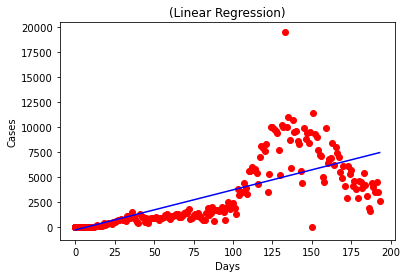

In [390]:
#display the cases with linear regression on a plot
def viz_linear():
    plt.scatter(X, y, color='red')
    plt.plot(X, lm.predict(X), color='blue')
    plt.title('(Linear Regression)')
    plt.xlabel('Days')
    plt.ylabel('Cases')
    plt.show()
    return
viz_linear()

##### Polynomial regression of TX state cases

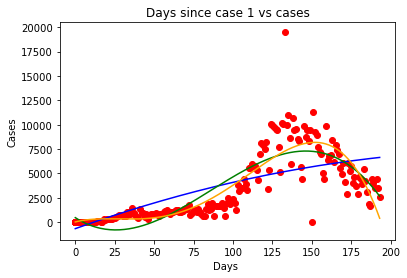

In [391]:
# Fitting Polynomial Regression to the dataset
from sklearn.preprocessing import PolynomialFeatures

poly_reg2 = PolynomialFeatures(degree=2)
X_poly2 = poly_reg2.fit_transform(X)
pol_reg2 = LinearRegression()
pol_reg2.fit(X_poly2, y)

poly_reg3 = PolynomialFeatures(degree=3)
X_poly3 = poly_reg3.fit_transform(X)
pol_reg3 = LinearRegression()
pol_reg3.fit(X_poly3, y)

poly_reg4 = PolynomialFeatures(degree=4)
X_poly4 = poly_reg4.fit_transform(X)
pol_reg4 = LinearRegression()
pol_reg4.fit(X_poly4, y)


# Visualizing the Polymonial Regression results
def viz_poly():
    plt.scatter(X, y, color='red')
    plt.plot(X,pol_reg2.predict(X_poly2),color='blue')
    plt.plot(X,pol_reg3.predict(X_poly3),color='green')
    plt.plot(X,pol_reg4.predict(X_poly4),color='orange')
    plt.title("Days since case 1 vs cases")
    plt.xlabel("Days ")
    plt.ylabel("Cases")
    plt.show()
    return
viz_poly()

##### Linear and ploynomial regression together along with the plot

R-square of state cases for degree 1 : 0.5553553490553018
RMSE of state deaths for degree 1 : 2255.4141067231167
R-square of state cases for degree 2 : 0.5648780380617129
RMSE of state deaths for degree 2 : 2231.1319654113904
R-square of state cases for degree 3 : 0.739881967988645
RMSE of state deaths for degree 3 : 1725.063102713248
R-square of state cases for degree 4 : 0.7850423455145379
RMSE of state deaths for degree 4 : 1568.1810940012806


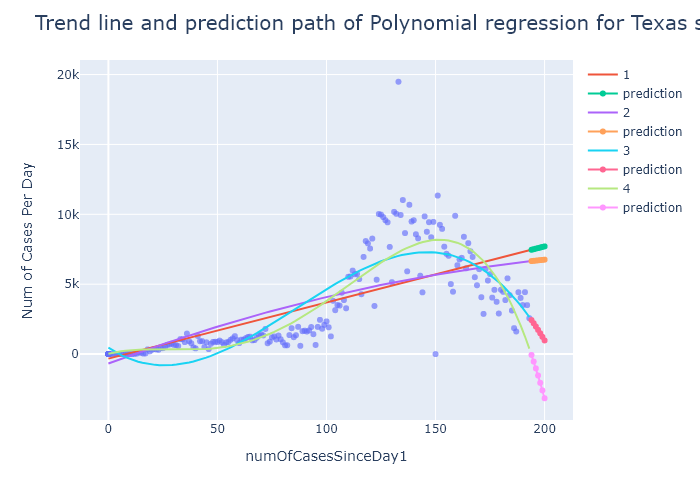

In [598]:
import plotly.express as px
import plotly.graph_objs as go

X = state_cases.numOfCasesSinceDay1.values.reshape(-1, 1)
y = state_cases['Num of Cases Per Day'].values.reshape(-1, 1)
x_range = np.linspace(X.min(), X.max(), 100).reshape(-1, 1)
x_range1 = np.linspace(future_dates.min(), future_dates.max(), 7).reshape(-1, 1)

tx_poly = px.scatter(state_cases, x='numOfCasesSinceDay1', y='Num of Cases Per Day', opacity=0.65)
for degree in [1, 2, 3, 4]:
    poly = PolynomialFeatures(degree)
    poly.fit(X)
    X_poly = poly.fit_transform(X)
    x_range_poly = poly.fit_transform(x_range)
    X_poly1 = poly.fit_transform(future_dates)
    x_range_poly1= poly.fit_transform(x_range1)
    
    model = LinearRegression()
    model.fit(X_poly, state_cases['Num of Cases Per Day'])
    y_poly = model.predict(x_range_poly)
    y_poly1 = model.predict(X_poly1)
    
    print("R-square of state cases for degree", degree,":", r2_score(y,model.predict(X_poly)))
    print("RMSE of state deaths for degree", degree,":", np.sqrt(metrics.mean_squared_error(y,model.predict(X_poly))))
    
    tx_poly.add_traces(go.Scatter(x=x_range.squeeze(), y=y_poly, name=degree))
    tx_poly.add_traces(go.Scatter(x=x_range1.squeeze(), y=y_poly1, name="prediction"))
#tx_poly.show()
    tx_poly.update_layout(title_text="Trend line and prediction path of Polynomial regression for Texas state cases",
                  title_font_size=20)
    
tx_poly.write_image("../images1/tx_poly.png")
img_bytes = tx_poly.to_image(format="png")
Image(img_bytes)

#### Polynomial regression using stats model to plot confidence interval

In [395]:
# We know from above that degree 3 fits well without overfitting
polynomial_features= PolynomialFeatures(degree=3)
xp = polynomial_features.fit_transform(X)
xp.shape

(236, 4)

In [396]:
#Fitting dta to the model
model = sm.OLS(y, xp).fit()
ypred = model.predict(xp) 
ypred.shape

(236,)

In [397]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.740
Model:                            OLS   Adj. R-squared:                  0.737
Method:                 Least Squares   F-statistic:                     220.0
Date:                Sun, 15 Nov 2020   Prob (F-statistic):           1.52e-67
Time:                        21:07:39   Log-Likelihood:                -2093.8
No. Observations:                 236   AIC:                             4196.
Df Residuals:                     232   BIC:                             4209.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        457.0808    235.462      1.941      0.053      -6.837     920.999
x1          -104.2289     14.444     -7.216      0.000    -132.688     -75.770
x2             2.3878      0.203     11.787      0.000       1.989       2.787
x3            -0.0093      0.001    -12.493      0.000      -0.011      -0.008
==============================================================================
Omnibus:                      104.450   Durbin-Watson:                   1.011
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1344.730
Skew:                           1.352   Prob(JB):                    9.90e-293
Kurtosis:                      14.377   Cond. No.                     5.16e+06
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 5.16e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

##### Plotting lower and upper confidence intervals

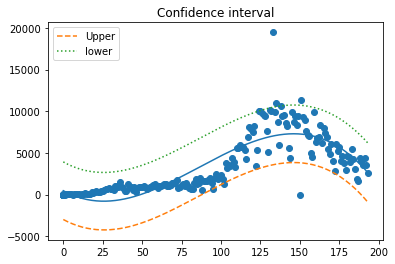

In [399]:
from statsmodels.sandbox.regression.predstd import wls_prediction_std
_, upper,lower = wls_prediction_std(model)
plt.title('Confidence interval')
plt.scatter(X,y)
plt.plot(X,ypred)
plt.plot()
plt.plot(X,upper,'--',label="Upper") # confid. intrvl
plt.plot(X,lower,':',label="lower")
plt.legend(loc='upper left')

#### We can see that for Texas state cases the polynomial regression of degree 3 is the best fitted with an Rsquare  of 0.74. Degree of 4 is over-fitted.


#### Deaths linear and polynomial regression

In [581]:
state_deaths = state_data_tx_date[['numOfDeathsSinceDay1','Num of Deaths Per Day']]
#state_cases = state_cases[state_cases.numOfCasesSinceDay1 != 0]
state_deaths

,numOfDeathsSinceDay1,Num of Deaths Per Day
0,0,0.0
1,0,0.0
2,0,0.0
3,0,0.0
4,0,0.0
...,...,...
231,178,161.0
232,179,144.0
233,180,147.0
234,181,47.0


In [582]:
#X variable is number of days and y variable is number of cases
X_d = state_deaths.iloc[:,0].values.reshape(-1, 1) 
y_d = state_deaths.iloc[:,1].values.reshape(-1, 1) 

 

In [583]:
#Creating liner regression model, fittig the data and prdicting the cases
lm = LinearRegression()
lm.fit(X_d, y_d)
deaths_prediction = lm.predict(X_d)

In [584]:
print("MSE score:",metrics.mean_squared_error(y_d,cases_prediction))
print("MAE score:",metrics.mean_absolute_error(y_d,cases_prediction))
print("RMSE score:",np.sqrt(metrics.mean_squared_error(y_d,cases_prediction)))
print("R^2 score:",r2_score(y_d,deaths_prediction))

MSE score: 13892767.415642764
MAE score: 2927.841239089664
RMSE score: 3727.300285145103
R^2 score: 0.31807891821027645


In [585]:
#Creating future dates
future_dates_d = np.arange(183,190).reshape(-1,1)
print(future_dates_d)

[[183]
 [184]
 [185]
 [186]
 [187]
 [188]
 [189]]


In [586]:
#Predicting future cases
future_deaths = lm.predict(future_dates_d)
#display the predicted cases for the future dates
print("Predicted Cases:")
for i in range(0, len(future_dates_d)):
    print(future_dates_d[i], '-', future_deaths[i])

Predicted Cases:
[183] - [175.80936719]
[184] - [176.83755678]
[185] - [177.86574636]
[186] - [178.89393595]
[187] - [179.92212553]
[188] - [180.95031512]
[189] - [181.9785047]


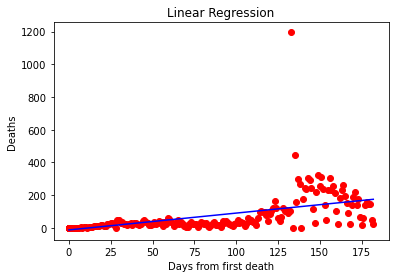

In [587]:
def viz_linear():
    plt.scatter(X_d, y_d, color='red')
    plt.plot(X_d, lm.predict(X_d), color='blue')
    plt.title('Linear Regression')
    plt.xlabel('Days from first death')
    plt.ylabel('Deaths')
    plt.show()
    return
viz_linear()

In [588]:
#Polynomial regression with different degrees
poly_d2 = PolynomialFeatures(degree = 2)
#Fitting the data
poly_d2.fit(X_d)
poly_features_d2 = poly_d2.fit_transform(X_d)
poly_regression_d2 = LinearRegression()
poly_regression_d2.fit(poly_features_d2,y_d)

poly_d3 = PolynomialFeatures(degree = 3)
poly_d3.fit(X_d)
poly_features_d3 = poly_d3.fit_transform(X_d)
poly_regression_d3 = LinearRegression()
poly_regression_d3.fit(poly_features_d3,y_d)

poly_d4 = PolynomialFeatures(degree = 4)
poly_d4.fit(X_d)
poly_features_d4 = poly_d4.fit_transform(X_d)
poly_regression_d4 = LinearRegression()
poly_regression_d4.fit(poly_features_d4,y_d)

poly_d5 = PolynomialFeatures(degree = 5)
poly_d5.fit(X_d)
poly_features_d5 = poly_d5.fit_transform(X_d)
poly_regression_d5 = LinearRegression()
poly_regression_d5.fit(poly_features_d5,y_d)


LinearRegression()

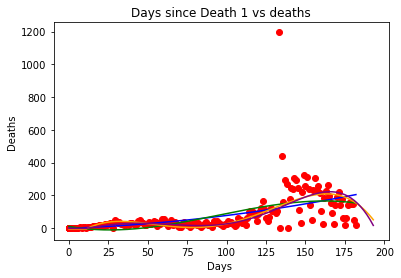

In [589]:
#ploting the data  for polynomial regression 
def viz_poly():
    plt.scatter(X_d, y_d, color='red')
    plt.plot(X_d,poly_regression_d2.predict(poly_features_d2),color='blue')
    plt.plot(X_d,poly_regression_d3.predict(poly_features_d3),color='green')
    plt.plot(X,poly_regression_d4.predict(poly_features_d4),color='orange')
    plt.plot(X,poly_regression_d5.predict(poly_features_d5),color='purple')
    plt.title("Days since Death 1 vs deaths")
    plt.xlabel("Days ")
    plt.ylabel("Deaths")
    plt.show()
    return
viz_poly()


In [590]:
poly_features_fd = poly_d3.fit_transform(future_dates_d)
poly_regression_d3.predict(poly_features_fd)


array([[151.83606667],
       [150.42605463],
       [148.94056488],
       [147.3787584 ],
       [145.73979619],
       [144.02283924],
       [142.22704854]])

In [591]:
print(poly_regression_d3.coef_)
# Computing the Y-intercept
print(poly_regression_d3.intercept_)
print(metrics.mean_squared_error(y_d,poly_regression_d3.predict(poly_features_d3)))
print("RMSE :", np.sqrt(metrics.mean_squared_error(y_d,poly_regression_d3.predict(poly_features_d3))))

[[ 0.00000000e+00 -1.76242451e+00  3.94498015e-02 -1.39834530e-04]]
[10.19944687]
7716.30971277806
RMSE : 87.84252792798065


In [592]:
r2_score(y_d,poly_regression_d3.predict(poly_features_d3))

0.3561712773689837

In [593]:
future_dates_d

array([[183],
       [184],
       [185],
       [186],
       [187],
       [188],
       [189]])

R-square of state deaths: 1 0.31807891821027634
RMSE of state deaths for degree 4355.208860545263
R-square of state deaths: 2 0.33013744023536173
RMSE of state deaths for degree 4356.589568111829
R-square of state deaths: 3 0.3561712773689837
RMSE of state deaths for degree 4350.863509042784
R-square of state deaths: 4 0.44046784900021896
RMSE of state deaths for degree 4346.846638264234
R-square of state deaths: 5 0.4487219177051206
RMSE of state deaths for degree 4348.37971226657


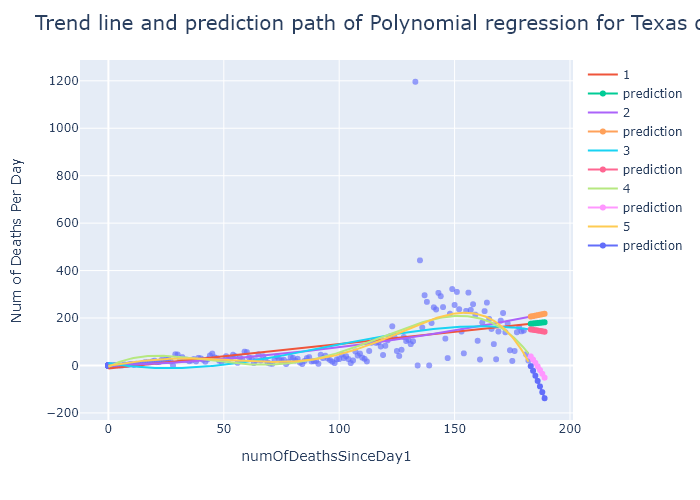

In [597]:
X_d = state_deaths.numOfDeathsSinceDay1.values.reshape(-1, 1)
y_d = state_deaths.iloc[:,1].values.reshape(-1, 1) 
x_range = np.linspace(X_d.min(), X_d.max(), 235).reshape(-1, 1)
x_range1 = np.linspace(future_dates_d.min(), future_dates_d.max(), 7).reshape(-1, 1)

tx_poly_d = px.scatter(state_deaths, x='numOfDeathsSinceDay1', y=state_deaths['Num of Deaths Per Day'], opacity=0.65)
for degree in [1, 2, 3, 4, 5]:
    poly = PolynomialFeatures(degree)
    poly.fit(X_d)
    X_poly = poly.fit_transform(X_d)
    x_range_poly = poly.fit_transform(x_range)
    X_poly1 = poly.fit_transform(future_dates_d)
    x_range_poly1= poly.fit_transform(x_range1)
    
    model = LinearRegression()
    model.fit(X_poly, state_deaths['Num of Deaths Per Day'])
    y_poly = model.predict(x_range_poly)
    y_poly1 = model.predict(x_range_poly1)
    print("R-square of state deaths:", degree, r2_score(y_d,model.predict(X_poly)))
    print("RMSE of state deaths for degree", np.sqrt(metrics.mean_squared_error(y,model.predict(X_poly))))
    tx_poly_d.add_traces(go.Scatter(x=x_range.squeeze(), y=y_poly, name=degree))
    tx_poly_d.add_traces(go.Scatter(x=x_range1.squeeze(), y=y_poly1, name="prediction"))
#tx_poly_d.show()
    tx_poly_d.update_layout(title_text="Trend line and prediction path of Polynomial regression for Texas deaths",
                  title_font_size=20)
    
tx_poly_d.write_image("../images1/tx_poly_d.png")
img_bytes = tx_poly_d.to_image(format="png")
Image(img_bytes)

In [288]:
# We know from above that degree 3 fits well without overfitting
polynomial_features= PolynomialFeatures(degree=3)
xp = polynomial_features.fit_transform(X_d)
xp.shape


(236, 4)

In [292]:
model = sm.OLS(y_d, xp).fit()
ypred = model.predict(xp) 

ypred.shape


(236,)

In [290]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.356
Model:                            OLS   Adj. R-squared:                  0.348
Method:                 Least Squares   F-statistic:                     42.78
Date:                Sun, 15 Nov 2020   Prob (F-statistic):           4.81e-22
Time:                        19:48:32   Log-Likelihood:                -1391.1
No. Observations:                 236   AIC:                             2790.
Df Residuals:                     232   BIC:                             2804.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         10.1994     10.996      0.928      0.355     -11.466      31.865
x1            -1.7624      0.769     -2.291      0.023      -3.278      -0.247
x2             0.0394      0.012      3.380      0.001       0.016       0.062
x3            -0.0001   4.57e-05     -3.063      0.002      -0.000   -4.99e-05
==============================================================================
Omnibus:                      366.173   Durbin-Watson:                   1.836
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            73256.195
Skew:                           7.394   Prob(JB):                         0.00
Kurtosis:                      88.036   Cond. No.                     3.86e+06
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.86e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

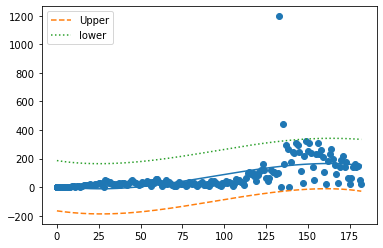

In [291]:
from statsmodels.sandbox.regression.predstd import wls_prediction_std
_, upper,lower = wls_prediction_std(model)

plt.scatter(X_d,y_d)
plt.plot(X_d,ypred)
plt.plot()
plt.plot(X_d,upper,'--',label="Upper") # confid. intrvl
plt.plot(X_d,lower,':',label="lower")
plt.legend(loc='upper left')

#### Counties models

In [599]:
#Choosing highly infected counties from previous phase of the project

count_1 = state_data_tx[state_data_tx["County Name"].isin(["maverick county"])]
count_2 = state_data_tx[state_data_tx["County Name"].isin(["willacy county"])]
count_3 = state_data_tx[state_data_tx["County Name"].isin(["bee county"])]
count_4 = state_data_tx[state_data_tx["County Name"].isin(["moore county"])]
count_5 = state_data_tx[state_data_tx["County Name"].isin(["hale county"])]


In [600]:
count_5

,State,countyFIPS,County Name,Date,population,Num of Cases Per Day,Num of Deaths Per Day
631132,TX,48189,hale county,2020-01-23,33406,0.0,0.0
631133,TX,48189,hale county,2020-01-24,33406,0.0,0.0
631134,TX,48189,hale county,2020-01-25,33406,0.0,0.0
631135,TX,48189,hale county,2020-01-26,33406,0.0,0.0
631136,TX,48189,hale county,2020-01-27,33406,0.0,0.0
...,...,...,...,...,...,...,...
631363,TX,48189,hale county,2020-09-10,33406,16.0,0.0
631364,TX,48189,hale county,2020-09-11,33406,2.0,0.0
631365,TX,48189,hale county,2020-09-12,33406,0.0,0.0
631366,TX,48189,hale county,2020-09-13,33406,0.0,0.0


In [601]:
f={'Num of Cases Per Day':'sum','Num of Deaths Per Day':'sum','population':'sum','County Name':'first'}
county_grp = count_1.groupby("Date").agg(f).reset_index()
county_grp

f={'Num of Cases Per Day':'sum','Num of Deaths Per Day':'sum','population':'sum','County Name':'first'}
county_grp2 = count_2.groupby("Date").agg(f).reset_index()

f={'Num of Cases Per Day':'sum','Num of Deaths Per Day':'sum','population':'sum','County Name':'first'}
county_grp3 = count_3.groupby("Date").agg(f).reset_index()

f={'Num of Cases Per Day':'sum','Num of Deaths Per Day':'sum','population':'sum','County Name':'first'}
county_grp4 = count_4.groupby("Date").agg(f).reset_index()

f={'Num of Cases Per Day':'sum','Num of Deaths Per Day':'sum','population':'sum','County Name':'first'}
county_grp5 = count_5.groupby("Date").agg(f).reset_index()


In [602]:
first_case_county1_index = county_grp['Num of Cases Per Day'].ne(0).idxmax() 
first_death_county1_index= county_grp['Num of Deaths Per Day'].ne(0).idxmax() 

first_case_county2_index = county_grp2['Num of Cases Per Day'].ne(0).idxmax() 
first_death_county2_index= county_grp2['Num of Deaths Per Day'].ne(0).idxmax() 

first_case_county3_index = county_grp3['Num of Cases Per Day'].ne(0).idxmax() 
first_death_county3_index= county_grp3['Num of Deaths Per Day'].ne(0).idxmax() 

first_case_county4_index = county_grp4['Num of Cases Per Day'].ne(0).idxmax() 
first_death_county4_index= county_grp4['Num of Deaths Per Day'].ne(0).idxmax() 

first_case_county5_index = county_grp5['Num of Cases Per Day'].ne(0).idxmax() 
first_death_county5_index= county_grp5['Num of Deaths Per Day'].ne(0).idxmax() 

In [603]:
numOfCasesSinceDay1=[]
counter=1
for i,index in enumerate(range(len(county_grp))):
    if i<=first_case_county1_index:
        numOfCasesSinceDay1.insert(index, 0) 
    else:
        numOfCasesSinceDay1.insert(index, counter) 
        counter = counter+1
        
#print(numOfCasesSinceDay1) 
county_grp.insert(2, "numOfCasesSinceDay1", numOfCasesSinceDay1)
# county_grp.tail()

numOfCasesSinceDay1=[]
counter=1
for i,index in enumerate(range(len(county_grp2))):
    if i<=first_case_county2_index:
        numOfCasesSinceDay1.insert(index, 0) 
    else:
        numOfCasesSinceDay1.insert(index, counter) 
        counter = counter+1
        
#print(numOfCasesSinceDay1) 
county_grp2.insert(2, "numOfCasesSinceDay1", numOfCasesSinceDay1)
# county_grp.tail()

numOfCasesSinceDay1=[]
counter=1
for i,index in enumerate(range(len(county_grp3))):
    if i<=first_case_county3_index:
        numOfCasesSinceDay1.insert(index, 0) 
    else:
        numOfCasesSinceDay1.insert(index, counter) 
        counter = counter+1
        
#print(numOfCasesSinceDay1) 
county_grp3.insert(2, "numOfCasesSinceDay1", numOfCasesSinceDay1)
# county_grp.tail()

numOfCasesSinceDay1=[]
counter=1
for i,index in enumerate(range(len(county_grp4))):
    if i<=first_case_county4_index:
        numOfCasesSinceDay1.insert(index, 0) 
    else:
        numOfCasesSinceDay1.insert(index, counter) 
        counter = counter+1
        
#print(numOfCasesSinceDay1) 
county_grp4.insert(2, "numOfCasesSinceDay1", numOfCasesSinceDay1)
# county_grp.tail()

numOfCasesSinceDay1=[]
counter=1
for i,index in enumerate(range(len(county_grp5))):
    if i<=first_case_county5_index:
        numOfCasesSinceDay1.insert(index, 0) 
    else:
        numOfCasesSinceDay1.insert(index, counter) 
        counter = counter+1
        
#print(numOfCasesSinceDay1) 
county_grp5.insert(2, "numOfCasesSinceDay1", numOfCasesSinceDay1)
# county_grp.tail()

In [604]:
county_grp.tail()

,Date,Num of Cases Per Day,numOfCasesSinceDay1,Num of Deaths Per Day,population,County Name
231,2020-09-10,0.0,171,1.0,58722,maverick county
232,2020-09-11,41.0,172,0.0,58722,maverick county
233,2020-09-12,36.0,173,0.0,58722,maverick county
234,2020-09-13,0.0,174,0.0,58722,maverick county
235,2020-09-14,0.0,175,0.0,58722,maverick county


In [605]:
numOfDeathsSinceDay1=[]
counter=1
for i,index in enumerate(range(len(county_grp))):
    if i<=first_death_county1_index:
        numOfDeathsSinceDay1.insert(index, 0) 
    else:
        numOfDeathsSinceDay1.insert(index, counter) 
        counter = counter+1
        
#print(numOfCasesSinceDay1)   
county_grp.insert(2, "numOfDeathsSinceDay1", numOfDeathsSinceDay1)


numOfDeathsSinceDay1=[]
counter=1
for i,index in enumerate(range(len(county_grp2))):
    if i<=first_death_county2_index:
        numOfDeathsSinceDay1.insert(index, 0) 
    else:
        numOfDeathsSinceDay1.insert(index, counter) 
        counter = counter+1
        
#print(numOfCasesSinceDay1)   
county_grp2.insert(2, "numOfDeathsSinceDay1", numOfDeathsSinceDay1)


numOfDeathsSinceDay1=[]
counter=1
for i,index in enumerate(range(len(county_grp3))):
    if i<=first_death_county3_index:
        numOfDeathsSinceDay1.insert(index, 0) 
    else:
        numOfDeathsSinceDay1.insert(index, counter) 
        counter = counter+1
        
#print(numOfCasesSinceDay1)   
county_grp3.insert(2, "numOfDeathsSinceDay1", numOfDeathsSinceDay1)


numOfDeathsSinceDay1=[]
counter=1
for i,index in enumerate(range(len(county_grp4))):
    if i<=first_death_county4_index:
        numOfDeathsSinceDay1.insert(index, 0) 
    else:
        numOfDeathsSinceDay1.insert(index, counter) 
        counter = counter+1
        
#print(numOfCasesSinceDay1)   
county_grp4.insert(2, "numOfDeathsSinceDay1", numOfDeathsSinceDay1)


numOfDeathsSinceDay1=[]
counter=1
for i,index in enumerate(range(len(county_grp5))):
    if i<=first_death_county5_index:
        numOfDeathsSinceDay1.insert(index, 0) 
    else:
        numOfDeathsSinceDay1.insert(index, counter) 
        counter = counter+1
        
#print(numOfCasesSinceDay1)   
county_grp5.insert(2, "numOfDeathsSinceDay1", numOfDeathsSinceDay1)
county_grp5.tail()

,Date,Num of Cases Per Day,numOfDeathsSinceDay1,numOfCasesSinceDay1,Num of Deaths Per Day,population,County Name
231,2020-09-10,16.0,154,167,0.0,33406,hale county
232,2020-09-11,2.0,155,168,0.0,33406,hale county
233,2020-09-12,0.0,156,169,0.0,33406,hale county
234,2020-09-13,0.0,157,170,0.0,33406,hale county
235,2020-09-14,49.0,158,171,0.0,33406,hale county


In [606]:
#Normalising cases and deaths of counties per 10000 population
county_grp['cases_rate'] = (county_grp['Num of Cases Per Day']/county_grp['population'])*1000000
county_grp['deaths_rate'] = (county_grp['Num of Deaths Per Day']/county_grp['population'])*1000000

county_grp2['cases_rate'] = (county_grp2['Num of Cases Per Day']/county_grp['population'])*1000000
county_grp2['deaths_rate'] = (county_grp2['Num of Deaths Per Day']/county_grp['population'])*1000000

county_grp3['cases_rate'] = (county_grp3['Num of Cases Per Day']/county_grp['population'])*1000000
county_grp3['deaths_rate'] = (county_grp3['Num of Deaths Per Day']/county_grp['population'])*1000000

county_grp4['cases_rate'] = (county_grp4['Num of Cases Per Day']/county_grp['population'])*1000000
county_grp4['deaths_rate'] = (county_grp4['Num of Deaths Per Day']/county_grp['population'])*1000000

county_grp5['cases_rate'] = (county_grp5['Num of Cases Per Day']/county_grp['population'])*1000000
county_grp5['deaths_rate'] = (county_grp5['Num of Deaths Per Day']/county_grp['population'])*1000000


In [607]:
county_1_cases = county_grp[['numOfCasesSinceDay1','cases_rate']]
county_2_cases = county_grp2[['numOfCasesSinceDay1','cases_rate']]
county_3_cases = county_grp3[['numOfCasesSinceDay1','cases_rate']]
county_4_cases = county_grp4[['numOfCasesSinceDay1','cases_rate']]
county_5_cases = county_grp5[['numOfCasesSinceDay1','cases_rate']]
#state_cases = state_cases[state_cases.numOfCasesSinceDay1 != 0]
county_5_cases



,numOfCasesSinceDay1,cases_rate
0,0,0.000000
1,0,0.000000
2,0,0.000000
3,0,0.000000
4,0,0.000000
...,...,...
231,167,272.470284
232,168,34.058785
233,169,0.000000
234,170,0.000000


#### Linear regression for top 5 counties

In [608]:
X_c1 = county_1_cases.iloc[:,0].values.reshape(-1, 1) 
y_c1 = county_1_cases.iloc[:,1].values.reshape(-1, 1) 
lm_c1 = LinearRegression()
lm_c1.fit(X_c1, y_c1)
prediction_c1 = lm_c1.predict(X_c1)

X_c2 = county_2_cases.iloc[:,0].values.reshape(-1, 1) 
y_c2 = county_2_cases.iloc[:,1].values.reshape(-1, 1) 
lm_c2 = LinearRegression()
lm_c2.fit(X_c2, y_c2)
prediction_c2 = lm_c2.predict(X_c2)

X_c3 = county_3_cases.iloc[:,0].values.reshape(-1, 1) 
y_c3 = county_3_cases.iloc[:,1].values.reshape(-1, 1) 
lm_c3 = LinearRegression()
lm_c3.fit(X_c3, y_c3)
prediction_c3 = lm_c3.predict(X_c3)

X_c4 = county_4_cases.iloc[:,0].values.reshape(-1, 1) 
y_c4 = county_4_cases.iloc[:,1].values.reshape(-1, 1) 
lm_c4 = LinearRegression()
lm_c4.fit(X_c4, y_c4)
prediction_c4 = lm_c4.predict(X_c4)

X_c5 = county_5_cases.iloc[:,0].values.reshape(-1, 1) 
y_c5 = county_5_cases.iloc[:,1].values.reshape(-1, 1) 
lm_c5 = LinearRegression()
lm_c5.fit(X_c5, y_c5)
prediction_c5 = lm_c5.predict(X_c5)

#### MSE values for all counties cases

In [609]:
print(np.sqrt(metrics.mean_squared_error(y_c1,prediction_c1)))
print(np.sqrt(metrics.mean_squared_error(y_c2,prediction_c2)))
print(np.sqrt(metrics.mean_squared_error(y_c3,prediction_c3)))
print(np.sqrt(metrics.mean_squared_error(y_c4,prediction_c4)))
print(np.sqrt(metrics.mean_squared_error(y_c5,prediction_c5)))

872.658199427816
290.5639903653404
374.7787162632133
228.5951079733073
282.42026133688375


#### R-square values for all counties cases

In [610]:
print(r2_score(y_c1,prediction_c1))
print(r2_score(y_c2,prediction_c2))
print(r2_score(y_c3,prediction_c3))
print(r2_score(y_c4,prediction_c4))
print(r2_score(y_c5,prediction_c5))

0.0928607805212961
0.09800942303991023
0.15885540682906052
4.349544440540587e-05
0.14975688133963083


In [611]:
county_2_cases

,numOfCasesSinceDay1,cases_rate
0,0,0.000000
1,0,0.000000
2,0,0.000000
3,0,0.000000
4,0,0.000000
...,...,...
231,167,34.058785
232,168,51.088178
233,169,17.029393
234,170,0.000000


In [612]:
future_dates1 = np.arange(176,183).reshape(-1,1)
# print(future_dates)
future_cases1 = lm_c1.predict(future_dates1)

future_dates2 = np.arange(172,179).reshape(-1,1)
# print(future_dates)
future_cases2 = lm_c2.predict(future_dates2)

future_dates3 = np.arange(160,167).reshape(-1,1)
# print(future_dates)
future_cases3 = lm_c3.predict(future_dates3)

future_dates4 = np.arange(169,176).reshape(-1,1)
# print(future_dates)
future_cases4 = lm_c4.predict(future_dates4)

future_dates5 = np.arange(172,179).reshape(-1,1)
# print(future_dates)
future_cases5 = lm_c5.predict(future_dates5)

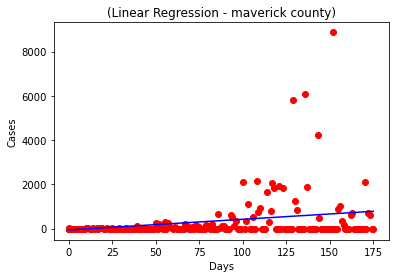

In [613]:
def viz_linear():
    plt.scatter(X_c1, y_c1, color='red')
    
    plt.plot(X_c1, prediction_c1, color='blue')
  
    plt.title('(Linear Regression - maverick county)')
    plt.xlabel('Days')
    plt.ylabel('Cases')
    plt.show()
    return
viz_linear()

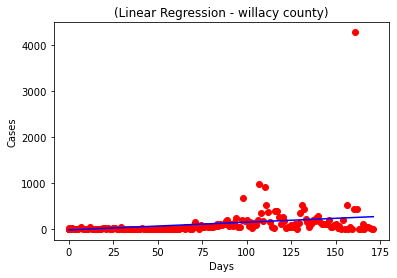

In [614]:
def viz_linear():
    plt.scatter(X_c2, y_c2, color='red')
    
    plt.plot(X_c2, prediction_c2, color='blue')
  
    plt.title('(Linear Regression - willacy county)')
    plt.xlabel('Days')
    plt.ylabel('Cases')
    plt.show()
    return
viz_linear()
    

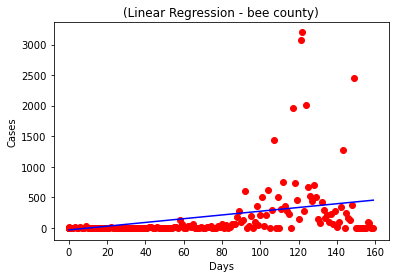

In [615]:
def viz_linear():
    plt.scatter(X_c3, y_c3, color='red')
    
    plt.plot(X_c3, prediction_c3, color='blue')
  
    plt.title('(Linear Regression - bee county)')
    plt.xlabel('Days')
    plt.ylabel('Cases')
    plt.show()
    return
viz_linear()
    

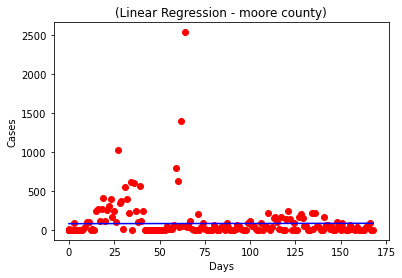

In [616]:
def viz_linear():
    plt.scatter(X_c4, y_c4, color='red')
    
    plt.plot(X_c4, prediction_c4, color='blue')
  
    plt.title('(Linear Regression - moore county)')
    plt.xlabel('Days')
    plt.ylabel('Cases')
    plt.show()
    return
viz_linear()
    

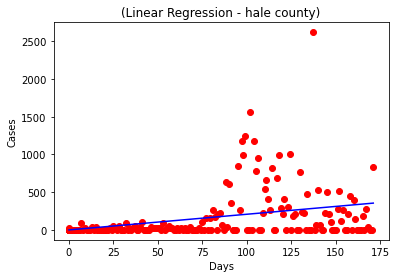

In [617]:
def viz_linear():
    plt.scatter(X_c5, y_c5, color='red')
    
    plt.plot(X_c5, prediction_c5, color='blue')
  
    plt.title('(Linear Regression - hale county)')
    plt.xlabel('Days')
    plt.ylabel('Cases')
    plt.show()
    return
viz_linear()
    

##### Polynomial regression for maverick county cases

R square score of degree 1 0.0928607805212961
RMSE of degree 1 872.658199427816
R square score of degree 2 0.09293554422059347
RMSE of degree 2 872.6222377484221
R square score of degree 3 0.12336743982670739
RMSE of degree 3 857.8591748472528
R square score of degree 4 0.13760677485961015
RMSE of degree 4 850.8634528707113
R square score of degree 5 0.13787929123453002
RMSE of degree 5 850.7290057658788


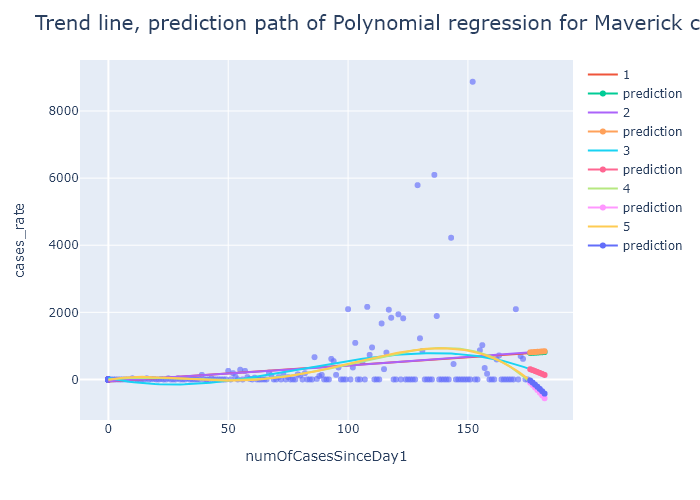

In [622]:
X_c1 = county_1_cases.iloc[:,0].values.reshape(-1, 1) 
y_c1 = county_1_cases.iloc[:,1].values.reshape(-1, 1) 
x_range = np.linspace(X_c1.min(), X_c1.max(), 100).reshape(-1, 1)
x_range1 = np.linspace(future_dates1.min(), future_dates1.max(), 7).reshape(-1, 1)

tx_c = px.scatter(county_1_cases, x='numOfCasesSinceDay1', y='cases_rate', opacity=0.65)
for degree in [1, 2, 3, 4, 5]:
    poly = PolynomialFeatures(degree)
    poly.fit(X_c1)
    X_poly = poly.fit_transform(X_c1)
    X_poly1 = poly.fit_transform(future_dates1)
    x_range_poly = poly.fit_transform(x_range)
    x_range_poly1= poly.fit_transform(x_range1)    

    model = LinearRegression(fit_intercept=False)
    model.fit(X_poly, county_1_cases['cases_rate'])
    y_poly = model.predict(x_range_poly)
    y_poly1 = model.predict(x_range_poly1)
    
    print("R square score of degree",degree,r2_score(y_c1,model.predict(X_poly)))
    print("RMSE of degree",degree,np.sqrt(metrics.mean_squared_error(y_c1,model.predict(X_poly))))
    tx_c.add_traces(go.Scatter(x=x_range.squeeze(), y=y_poly, name=degree))
    tx_c.add_traces(go.Scatter(x=x_range1.squeeze(), y=y_poly1, name="prediction"))
    tx_c.update_layout(title_text="Trend line, prediction path of Polynomial regression for Maverick cases",
                  title_font_size=20)
    
#fig.show()

tx_c.write_image("../images1/tx_c.png")
img_bytes = tx_c.to_image(format="png")
Image(img_bytes)



#### Regression with degree 3 is the best fit for the maverick county

#### Confidence interval for maverick county cases

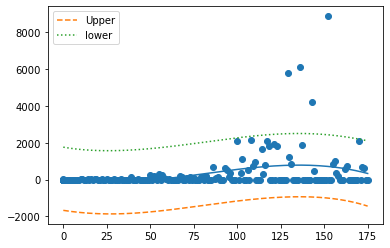

In [623]:
# We know from above that degree 3 fits well without overfitting
polynomial_features= PolynomialFeatures(degree=3)
xp = polynomial_features.fit_transform(X_c1)
xp.shape
model = sm.OLS(y_c1, xp).fit()
ypred = model.predict(xp) 

ypred.shape
from statsmodels.sandbox.regression.predstd import wls_prediction_std
_, upper,lower = wls_prediction_std(model)

plt.scatter(X_c1,y_c1)
plt.plot(X_c1,ypred)
plt.plot()
plt.plot(X_c1,upper,'--',label="Upper") # confid. intrvl
plt.plot(X_c1,lower,':',label="lower")
plt.legend(loc='upper left')

##### Polynomial regression for willacy county cases

R square score of degree 1 0.09800942303991023
RMSE of degree 1 290.5639903653404
R square score of degree 2 0.09996217941083752
RMSE of degree 2 290.24929300154724
R square score of degree 3 0.10588341040033578
RMSE of degree 3 289.2929614612967
R square score of degree 4 0.10591110585728314
RMSE of degree 4 289.288480970219


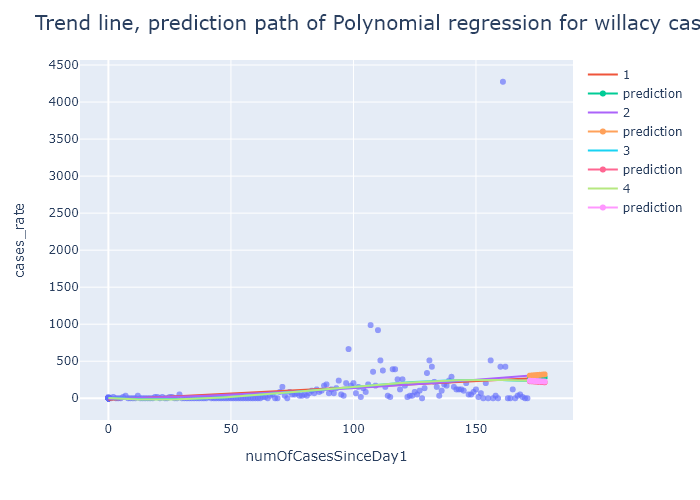

In [627]:
X_c2 = county_2_cases.iloc[:,0].values.reshape(-1, 1) 
y_c2 = county_2_cases.iloc[:,1].values.reshape(-1, 1) 
x_range = np.linspace(X_c2.min(), X_c2.max(), 100).reshape(-1, 1)
x_range1 = np.linspace(future_dates2.min(), future_dates2.max(), 7).reshape(-1, 1)

tx_c1 = px.scatter(county_2_cases, x='numOfCasesSinceDay1', y='cases_rate', opacity=0.65)
for degree in [1, 2, 3, 4]:
    poly = PolynomialFeatures(degree)
    poly.fit(X_c2)
    X_poly = poly.fit_transform(X_c2)
    X_poly1 = poly.fit_transform(future_dates2)
    x_range_poly1= poly.fit_transform(x_range1)
    x_range_poly = poly.transform(x_range)

    model = LinearRegression(fit_intercept=False)
    model.fit(X_poly, county_2_cases['cases_rate'])
    y_poly = model.predict(x_range_poly)
    y_poly1 = model.predict(x_range_poly1)
    
    print("R square score of degree",degree,r2_score(y_c2,model.predict(X_poly)))
    print("RMSE of degree",degree,np.sqrt(metrics.mean_squared_error(y_c2,model.predict(X_poly))))
    tx_c1.add_traces(go.Scatter(x=x_range.squeeze(), y=y_poly, name=degree))
    tx_c1.add_traces(go.Scatter(x=x_range1.squeeze(), y=y_poly1, name="prediction"))
#fig.show()
    tx_c1.update_layout(title_text="Trend line, prediction path of Polynomial regression for willacy cases",
                  title_font_size=20)
tx_c1.write_image("../images1/tx_c1.png")
img_bytes = tx_c1.to_image(format="png")
Image(img_bytes)

#### Confidence interval for willacy county cases

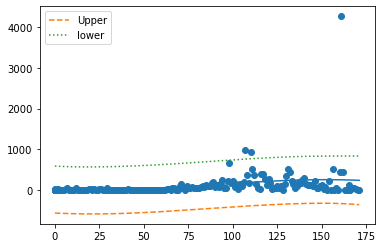

In [297]:
# We know from above that degree 3 fits well without overfitting
polynomial_features= PolynomialFeatures(degree=3)
xp = polynomial_features.fit_transform(X_c2)
xp.shape
model = sm.OLS(y_c2, xp).fit()
ypred = model.predict(xp) 

ypred.shape
from statsmodels.sandbox.regression.predstd import wls_prediction_std
_, upper,lower = wls_prediction_std(model)

plt.scatter(X_c2,y_c2)
plt.plot(X_c2,ypred)
plt.plot()
plt.plot(X_c2,upper,'--',label="Upper") # confid. intrvl
plt.plot(X_c2,lower,':',label="lower")
plt.legend(loc='upper left')

##### Polynomial regression for bee county cases

R square score of degree 1 0.15885540682906052
RMSE of degree 1 374.77871626321337
R square score of degree 2 0.1605279441698696
RMSE of degree 2 374.40592464589804
R square score of degree 3 0.22683047001013668
RMSE of degree 3 359.31633038972006
R square score of degree 4 0.27747065829329887
RMSE of degree 4 347.3500251251598


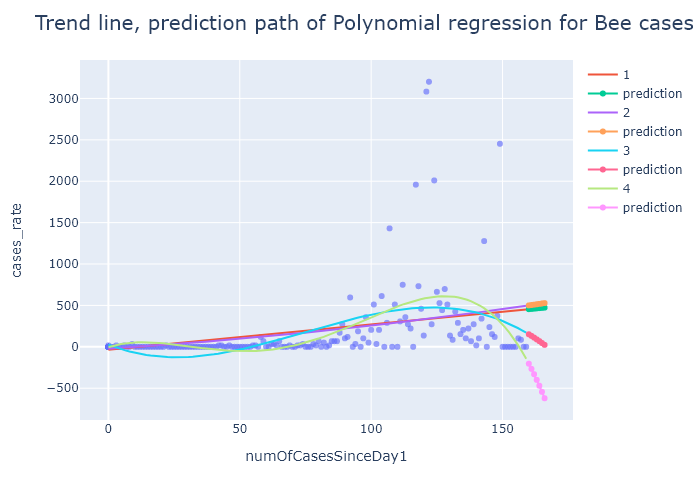

In [628]:
X_c3 = county_3_cases.iloc[:,0].values.reshape(-1, 1)
y_c3 = county_3_cases.iloc[:,1].values.reshape(-1, 1)
x_range = np.linspace(X_c3.min(), X_c3.max(), 100).reshape(-1, 1)
x_range1 = np.linspace(future_dates3.min(), future_dates3.max(), 7).reshape(-1, 1)

tx_c2 = px.scatter(county_3_cases, x='numOfCasesSinceDay1', y='cases_rate', opacity=0.65)
for degree in [1, 2, 3, 4]:
    poly = PolynomialFeatures(degree)
    poly.fit(X_c3)
    X_poly = poly.transform(X_c3)
    x_range_poly = poly.transform(x_range)
    X_poly1 = poly.fit_transform(future_dates3)
    x_range_poly1= poly.fit_transform(x_range1)

    model = LinearRegression(fit_intercept=False)
    model.fit(X_poly, county_3_cases['cases_rate'])
    y_poly = model.predict(x_range_poly)
    y_poly1 = model.predict(x_range_poly1)
    print("R square score of degree",degree,r2_score(y_c3,model.predict(X_poly)))
    print("RMSE of degree",degree,np.sqrt(metrics.mean_squared_error(y_c3,model.predict(X_poly))))
    tx_c2.add_traces(go.Scatter(x=x_range.squeeze(), y=y_poly, name=degree))

    tx_c2.add_traces(go.Scatter(x=x_range1.squeeze(), y=y_poly1, name="prediction"))
#fig.show()
    tx_c2.update_layout(title_text="Trend line, prediction path of Polynomial regression for Bee cases",
                  title_font_size=20)
    
tx_c2.write_image("../images1/tx_c2.png")
img_bytes = tx_c2.to_image(format="png")
Image(img_bytes)

##### Confidence interval

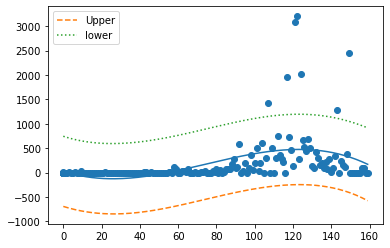

In [308]:
# We know from above that degree 3 fits well without overfitting
polynomial_features= PolynomialFeatures(degree=3)
xp = polynomial_features.fit_transform(X_c3)
xp.shape
model = sm.OLS(y_c3, xp).fit()
ypred = model.predict(xp) 

ypred.shape
from statsmodels.sandbox.regression.predstd import wls_prediction_std
_, upper,lower = wls_prediction_std(model)

plt.scatter(X_c3,y_c3)
plt.plot(X_c3,ypred)
plt.plot()
plt.plot(X_c3,upper,'--',label="Upper") # confid. intrvl
plt.plot(X_c3,lower,':',label="lower")
plt.legend(loc='upper left')

##### Polynomial regression for moore county cases

R square score of degree 1 4.349544440540587e-05
RMSE of degree 1 228.5951079733073
R square score of degree 2 0.060570135375443424
RMSE of degree 2 221.5687759123003
R square score of degree 3 0.11690118261056792
RMSE of degree 3 214.82312444686332
R square score of degree 4 0.14347864950155742
RMSE of degree 4 211.56580448808432


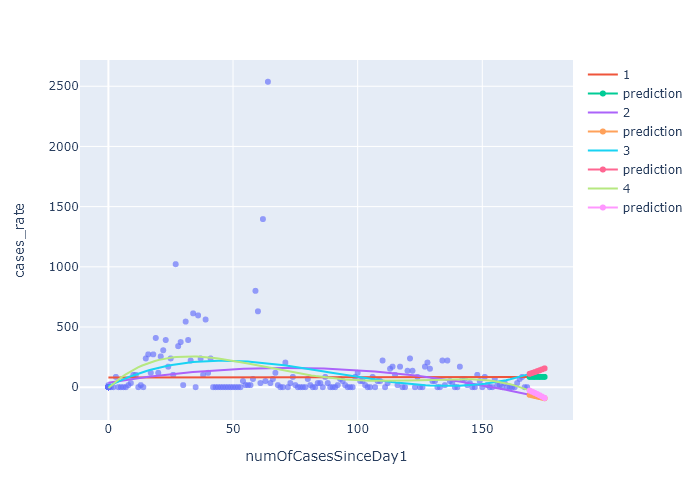

In [629]:
X_c4 = county_4_cases.iloc[:,0].values.reshape(-1, 1) 
y_c4 = county_4_cases.iloc[:,1].values.reshape(-1, 1) 
x_range = np.linspace(X_c4.min(), X_c4.max(), 100).reshape(-1, 1)
x_range1 = np.linspace(future_dates4.min(), future_dates4.max(), 7).reshape(-1, 1)

tx_c3 = px.scatter(county_4_cases, x='numOfCasesSinceDay1', y='cases_rate', opacity=0.65)
for degree in [1, 2, 3, 4]:
    poly = PolynomialFeatures(degree)
    poly.fit(X_c4)
    X_poly = poly.fit_transform(X_c4)
    x_range_poly = poly.fit_transform(x_range)
    X_poly1 = poly.fit_transform(future_dates4)
    x_range_poly1 = poly.fit_transform(x_range1)
    
    
    model = LinearRegression(fit_intercept=False)
    model.fit(X_poly, county_4_cases['cases_rate'])
    y_poly = model.predict(x_range_poly)
    y_poly1 = model.predict(x_range_poly1)
    print("R square score of degree",degree,r2_score(y_c4,model.predict(X_poly)))
    tx_c3.add_traces(go.Scatter(x=x_range.squeeze(), y=y_poly, name=degree))

    tx_c3.add_traces(go.Scatter(x=x_range1.squeeze(), y=y_poly1, name="prediction"))
#fig.show()
    print("RMSE of degree",degree,np.sqrt(metrics.mean_squared_error(y_c4,model.predict(X_poly))))
    tx_c4.update_layout(title_text="Trend line, prediction path of Polynomial regression for Moore cases",
                  title_font_size=20)
tx_c3.write_image("../images1/tx_c3.png")
img_bytes = tx_c3.to_image(format="png")
Image(img_bytes)

##### Confidence interval

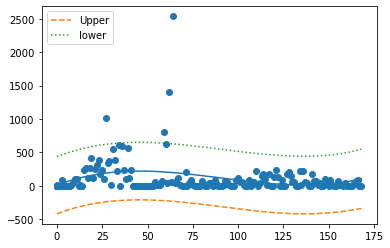

In [310]:
# We know from above that degree 3 fits well without overfitting
polynomial_features= PolynomialFeatures(degree=3)
xp = polynomial_features.fit_transform(X_c4)
xp.shape
model = sm.OLS(y_c4, xp).fit()
ypred = model.predict(xp) 

ypred.shape
from statsmodels.sandbox.regression.predstd import wls_prediction_std
_, upper,lower = wls_prediction_std(model)

plt.scatter(X_c4,y_c4)
plt.plot(X_c4,ypred)
plt.plot()
plt.plot(X_c4,upper,'--',label="Upper") # confid. intrvl
plt.plot(X_c4,lower,':',label="lower")
plt.legend(loc='upper left')

##### Polynomial regression for hale county cases

R square score of degree 1 0.14975688133963072
RMSE of degree 1 282.42026133688375
R square score of degree 2 0.16670226244998654
RMSE of degree 2 279.5917735974861
R square score of degree 3 0.2376143015462715
RMSE of degree 3 267.43094447321675
R square score of degree 4 0.23804348542715736
RMSE of degree 4 267.3556589525209


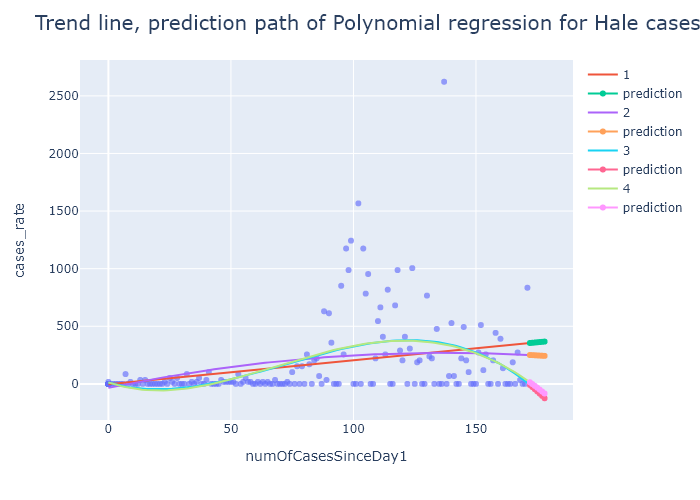

In [630]:
X_c5 = county_5_cases.iloc[:,0].values.reshape(-1, 1) 
y_c5 = county_5_cases.iloc[:,1].values.reshape(-1, 1)

x_range = np.linspace(X_c5.min(), X_c5.max(), 100).reshape(-1, 1)
x_range1 = np.linspace(future_dates5.min(), future_dates5.max(), 7).reshape(-1, 1)

tx_c4 = px.scatter(county_5_cases, x='numOfCasesSinceDay1', y='cases_rate', opacity=0.65)
for degree in [1, 2, 3, 4]:
    poly = PolynomialFeatures(degree)
    poly.fit(X_c5)
    X_poly = poly.fit_transform(X_c5)
    x_range_poly = poly.fit_transform(x_range)
    X_poly1 = poly.fit_transform(future_dates4)
    x_range_poly1 = poly.fit_transform(x_range1)
    
    model = LinearRegression(fit_intercept=False)
    model.fit(X_poly, county_5_cases['cases_rate'])
    y_poly = model.predict(x_range_poly)
    y_poly1 = model.predict(x_range_poly1)
    print("R square score of degree",degree,r2_score(y_c5,model.predict(X_poly)))
    tx_c4.add_traces(go.Scatter(x=x_range.squeeze(), y=y_poly, name=degree))
    tx_c4.add_traces(go.Scatter(x=x_range1.squeeze(), y=y_poly1, name="prediction"))
    print("RMSE of degree",degree,np.sqrt(metrics.mean_squared_error(y_c5,model.predict(X_poly))))
    tx_c4.update_layout(title_text="Trend line, prediction path of Polynomial regression for Hale cases",
                  title_font_size=20)
#fig.show()

tx_c4.write_image("../images1/tx_c4.png")
img_bytes = tx_c4.to_image(format="png")
Image(img_bytes)


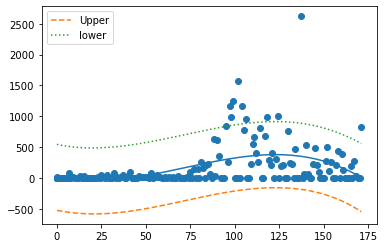

In [314]:
# We know from above that degree 3 fits well without overfitting
polynomial_features= PolynomialFeatures(degree=3)
xp = polynomial_features.fit_transform(X_c5)
xp.shape
model = sm.OLS(y_c5, xp).fit()
ypred = model.predict(xp) 

ypred.shape
from statsmodels.sandbox.regression.predstd import wls_prediction_std
_, upper,lower = wls_prediction_std(model)

plt.scatter(X_c5,y_c5)
plt.plot(X_c5,ypred)
plt.plot()
plt.plot(X_c5,upper,'--',label="Upper") # confid. intrvl
plt.plot(X_c5,lower,':',label="lower")
plt.legend(loc='upper left')

In [315]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.238
Model:                            OLS   Adj. R-squared:                  0.228
Method:                 Least Squares   F-statistic:                     24.10
Date:                Sun, 15 Nov 2020   Prob (F-statistic):           1.29e-13
Time:                        20:07:35   Log-Likelihood:                -1653.8
No. Observations:                 236   AIC:                             3316.
Df Residuals:                     232   BIC:                             3330.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         10.8330     31.099      0.348      0.728     -50.439      72.105
x1            -5.9667      2.485     -2.401      0.017     -10.863      -1.070
x2             0.1705      0.041      4.179      0.000       0.090       0.251
x3            -0.0008      0.000     -4.645      0.000      -0.001      -0.000
==============================================================================
Omnibus:                      223.876   Durbin-Watson:                   2.037
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             6091.340
Skew:                           3.680   Prob(JB):                         0.00
Kurtosis:                      26.776   Cond. No.                     2.88e+06
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.88e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

#### Death regression models for counties

In [631]:
county_1_deaths = county_grp[['numOfDeathsSinceDay1','deaths_rate']]
county_2_deaths = county_grp2[['numOfDeathsSinceDay1','deaths_rate']]
county_3_deaths = county_grp3[['numOfDeathsSinceDay1','deaths_rate']]
county_4_deaths = county_grp4[['numOfDeathsSinceDay1','deaths_rate']]
county_5_deaths = county_grp5[['numOfDeathsSinceDay1','deaths_rate']]
#state_cases = state_cases[state_cases.numOfCasesSinceDay1 != 0]




#### Linear regression for top 5 county deaths

In [632]:
X_d1 = county_1_deaths.iloc[:,0].values.reshape(-1, 1) 
y_d1 = county_1_deaths.iloc[:,1].values.reshape(-1, 1) 
lm_d1 = LinearRegression()
lm_d1.fit(X_d1, y_d1)
prediction_d1 = lm_d1.predict(X_d1)

X_d2 = county_2_deaths.iloc[:,0].values.reshape(-1, 1) 
y_d2 = county_2_deaths.iloc[:,1].values.reshape(-1, 1) 
lm_d2 = LinearRegression()
lm_d2.fit(X_d2, y_d2)
prediction_d2 = lm_d2.predict(X_d2)

X_d3 = county_3_deaths.iloc[:,0].values.reshape(-1, 1) 
y_d3 = county_3_deaths.iloc[:,1].values.reshape(-1, 1) 
lm_d3 = LinearRegression()
lm_d3.fit(X_d3, y_d3)
prediction_d3 = lm_d3.predict(X_d3)

X_d4 = county_4_deaths.iloc[:,0].values.reshape(-1, 1) 
y_d4 = county_4_deaths.iloc[:,1].values.reshape(-1, 1) 
lm_d4 = LinearRegression()
lm_d4.fit(X_d4, y_d4)
prediction_d4 = lm_d4.predict(X_d4)

X_d5 = county_5_deaths.iloc[:,0].values.reshape(-1, 1) 
y_d5 = county_5_deaths.iloc[:,1].values.reshape(-1, 1) 
lm_d5 = LinearRegression()
lm_d5.fit(X_d5, y_d5)
prediction_d5 = lm_d5.predict(X_d5)

In [633]:
print("MSE scores for top 5 county deaths: ")
print(np.sqrt(metrics.mean_squared_error(y_d1,prediction_d1)))
print(np.sqrt(metrics.mean_squared_error(y_d2,prediction_d2)))
print(np.sqrt(metrics.mean_squared_error(y_d3,prediction_d3)))
print(np.sqrt(metrics.mean_squared_error(y_d4,prediction_d4)))
print(np.sqrt(metrics.mean_squared_error(y_d5,prediction_d5)))

MSE scores for top 5 county deaths: 
21.883247204826162
15.675472235577912
7.7223374075704605
5.365181900865187
10.955698816607159


In [634]:
print("RMSE scores for top 5 county deaths: ")
print(r2_score(y_d1,prediction_d1))
print(r2_score(y_d2,prediction_d2))
print(r2_score(y_d3,prediction_d3))
print(r2_score(y_d4,prediction_d4))
print(r2_score(y_d5,prediction_d5))

RMSE scores for top 5 county deaths: 
0.19133892315643808
0.061344493796208766
0.09981099872573795
0.0019249023800764764
0.10244700451900735


In [635]:
county_2_deaths.tail()

,numOfDeathsSinceDay1,deaths_rate
231,158,17.029393
232,159,17.029393
233,160,0.000000
234,161,0.000000
235,162,0.000000


##### Predicting deaths of top 5 counties using linear regression

In [636]:
#Future dates are  dates for next 1 week

future_d_dates1 = np.arange(118,125).reshape(-1,1)
# print(future_dates)
future_deaths1 = lm_d1.predict(future_d_dates1)

future_d_dates2 = np.arange(163,170).reshape(-1,1)
# print(future_dates)
future_deaths2 = lm_d2.predict(future_d_dates2)

future_d_dates3 = np.arange(60,67).reshape(-1,1)
# print(future_dates)
future_deaths3 = lm_d3.predict(future_d_dates3)

future_d_dates4 = np.arange(148,155).reshape(-1,1)
# print(future_dates)
future_deaths4 = lm_d4.predict(future_d_dates4)

future_d_dates5 = np.arange(159,166).reshape(-1,1)
# print(future_dates)
future_deaths5 = lm_d5.predict(future_d_dates5)



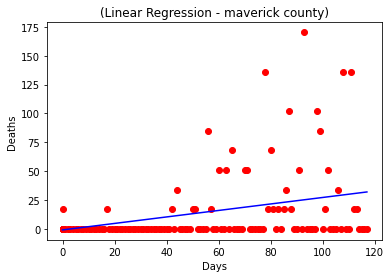

In [637]:
def viz_linear():
    plt.scatter(X_d1, y_d1, color='red')
    plt.plot(X_d1, prediction_d1, color='blue')
    plt.title('(Linear Regression - maverick county)')
    plt.xlabel('Days')
    plt.ylabel('Deaths')
    plt.show()
    return
viz_linear()

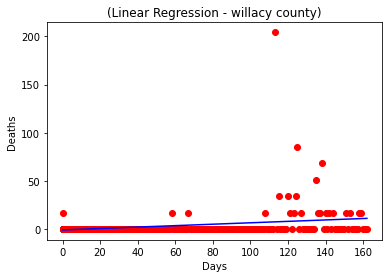

In [638]:
def viz_linear():
    plt.scatter(X_d2, y_d2, color='red')
    
    plt.plot(X_d2, prediction_d2, color='blue')
  
    plt.title('(Linear Regression - willacy county)')
    plt.xlabel('Days')
    plt.ylabel('Deaths')
    plt.show()
    return
viz_linear()

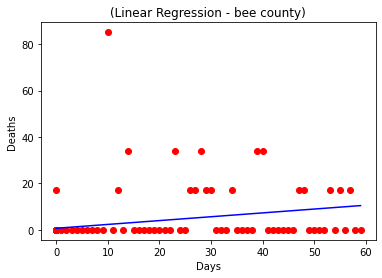

In [639]:
def viz_linear():
    plt.scatter(X_d3, y_d3, color='red')
    
    plt.plot(X_d3, prediction_d3, color='blue')
  
    plt.title('(Linear Regression - bee county)')
    plt.xlabel('Days')
    plt.ylabel('Deaths')
    plt.show()
    return
viz_linear()

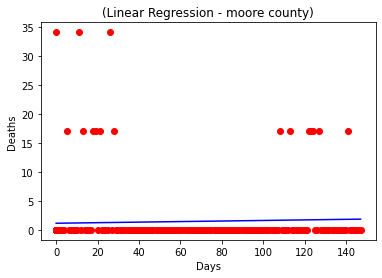

In [640]:

def viz_linear():
    plt.scatter(X_d4, y_d4, color='red')
    
    plt.plot(X_d4, prediction_d4, color='blue')
  
    plt.title('(Linear Regression - moore county)')
    plt.xlabel('Days')
    plt.ylabel('Deaths')
    plt.show()
    return
viz_linear()

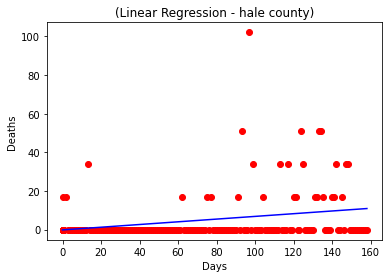

In [641]:
def viz_linear():
    plt.scatter(X_d5, y_d5, color='red')
    
    plt.plot(X_d5, prediction_d5, color='blue')
  
    plt.title('(Linear Regression - hale county)')
    plt.xlabel('Days')
    plt.ylabel('Deaths')
    plt.show()
    return
viz_linear()

##### Polynomial and linear regression for Maverick county deaths

R square score of degree 1 0.1913389231564382
RMSE of degree 1 21.88324720482616
R square score of degree 2 0.19196666790650763
RMSE of degree 2 21.87475182838082
R square score of degree 3 0.21602369960659995
RMSE of degree 3 21.546660243981606
R square score of degree 4 0.22273758983374092
RMSE of degree 4 21.454200202629558
R square score of degree 5 0.22402728226270874
RMSE of degree 5 21.436393599288962


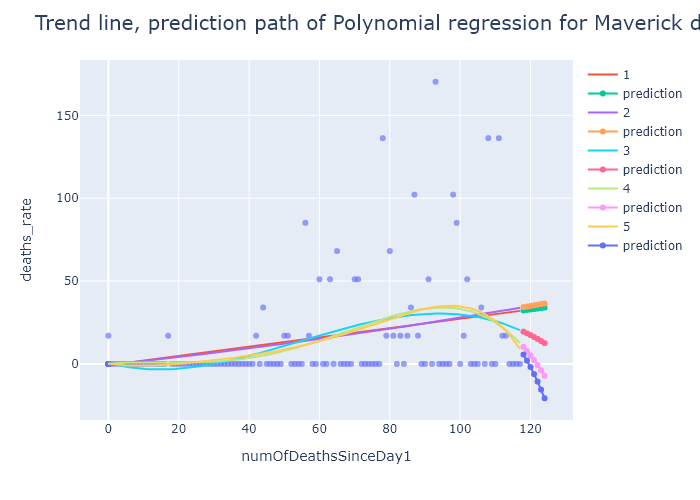

In [642]:
X_d1 = county_1_deaths.iloc[:,0].values.reshape(-1, 1) 
y_d1 = county_1_deaths.iloc[:,1].values.reshape(-1, 1) 
x_range = np.linspace(X_d1.min(), X_d1.max(), 100).reshape(-1, 1)
x_range1 = np.linspace(future_d_dates1.min(), future_d_dates1.max(), 7).reshape(-1, 1)

tx_d1 = px.scatter(county_1_deaths, x='numOfDeathsSinceDay1', y='deaths_rate', opacity=0.65)
for degree in [1, 2, 3, 4, 5]:
    poly = PolynomialFeatures(degree)
    poly.fit(X_d1)
    X_poly = poly.transform(X_d1)
    x_range_poly = poly.transform(x_range)
    X_poly1 = poly.fit_transform(future_d_dates1)
    x_range_poly1 = poly.fit_transform(x_range1)
    
    model = LinearRegression(fit_intercept=False)
    model.fit(X_poly, county_1_deaths['deaths_rate'])
    print("R square score of degree",degree,r2_score(y_d1,model.predict(X_poly)))
    y_poly = model.predict(x_range_poly)
    y_poly1 = model.predict(x_range_poly1)
    tx_d1.add_traces(go.Scatter(x=x_range.squeeze(), y=y_poly, name=degree))
    tx_d1.add_traces(go.Scatter(x=x_range1.squeeze(), y=y_poly1, name="prediction"))
#fig.show()
    print("RMSE of degree",degree,np.sqrt(metrics.mean_squared_error(y_d1,model.predict(X_poly))))
    tx_d1.update_layout(title_text="Trend line, prediction path of Polynomial regression for Maverick deaths",
                  title_font_size=20)

tx_d1.write_image("../images1/tx_d1.png")
img_bytes = tx_d1.to_image(format="png")
Image(img_bytes)


##### Confidence interval

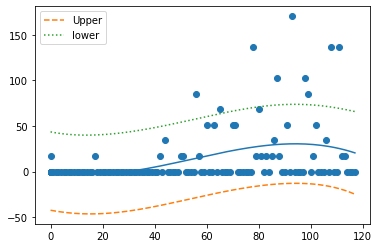

In [317]:
# We know from above that degree 3 fits better without overfitting
polynomial_features= PolynomialFeatures(degree=3)
xp = polynomial_features.fit_transform(X_d1)
xp.shape
model = sm.OLS(y_d1, xp).fit()
ypred = model.predict(xp) 

ypred.shape
from statsmodels.sandbox.regression.predstd import wls_prediction_std
_, upper,lower = wls_prediction_std(model)

plt.scatter(X_d1,y_d1)
plt.plot(X_d1,ypred)
plt.plot()
plt.plot(X_d1,upper,'--',label="Upper") # confid. intrvl
plt.plot(X_d1,lower,':',label="lower")
plt.legend(loc='upper left')

##### Polynomial and linear regression for Willacy county deaths

R square score of degree 1 0.061344493796208766
RMSE of degree 1 15.675472235577912
R square score of degree 2 0.06286086515804723
RMSE of degree 2 15.662805477294016
R square score of degree 3 0.08642956869543117
RMSE of degree 3 15.464594417921749
R square score of degree 4 0.10820054893335873
RMSE of degree 4 15.279217652051525
R square score of degree 5 0.10836017516061947
RMSE of degree 5 15.27785015119931


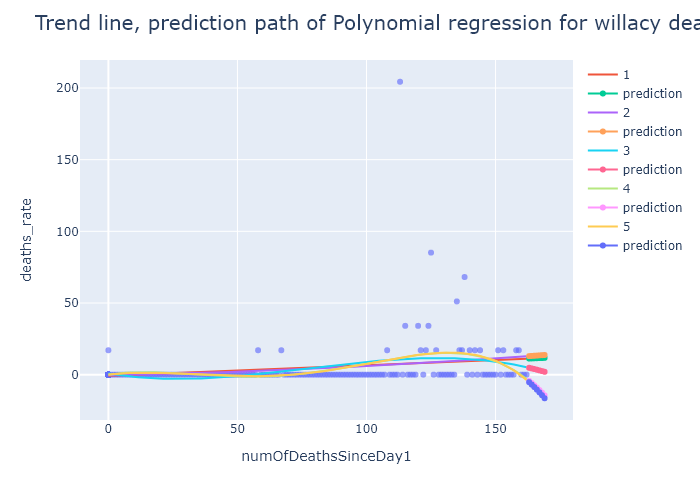

In [643]:
X_d2 = county_2_deaths.iloc[:,0].values.reshape(-1, 1) 
y_d2 = county_2_deaths.iloc[:,1].values.reshape(-1, 1)
x_range = np.linspace(X_d2.min(), X_d2.max(), 100).reshape(-1, 1)
x_range1 = np.linspace(future_d_dates2.min(), future_d_dates2.max(), 7).reshape(-1, 1)

tx_d2 = px.scatter(county_2_deaths, x='numOfDeathsSinceDay1', y='deaths_rate', opacity=0.65)
for degree in [1, 2, 3, 4, 5]:
    poly = PolynomialFeatures(degree)
    poly.fit(X_d2)
    X_poly = poly.transform(X_d2)
    x_range_poly = poly.transform(x_range)
    X_poly1 = poly.fit_transform(future_d_dates2)
    x_range_poly1 = poly.fit_transform(x_range1)
    
    model = LinearRegression(fit_intercept=False)
    model.fit(X_poly, county_2_deaths['deaths_rate'])
    print("R square score of degree",degree,r2_score(y_d2,model.predict(X_poly)))
    y_poly = model.predict(x_range_poly)
    y_poly1 = model.predict(x_range_poly1)
    tx_d2.add_traces(go.Scatter(x=x_range.squeeze(), y=y_poly, name=degree))
    tx_d2.add_traces(go.Scatter(x=x_range1.squeeze(), y=y_poly1, name="prediction"))
#fig.show()
    print("RMSE of degree",degree,np.sqrt(metrics.mean_squared_error(y_d2,model.predict(X_poly))))
    tx_d2.update_layout(title_text="Trend line, prediction path of Polynomial regression for willacy deaths",
                  title_font_size=20)
    
tx_d2.write_image("../images1/tx_d2.png")
img_bytes = tx_d2.to_image(format="png")
Image(img_bytes)

##### Confidence interval

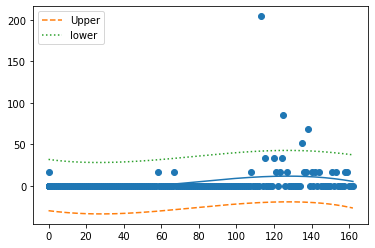

In [319]:
# We know from above that degree 3 fits better without overfitting
polynomial_features= PolynomialFeatures(degree=3)
xp = polynomial_features.fit_transform(X_d2)
xp.shape
model = sm.OLS(y_d2, xp).fit()
ypred = model.predict(xp) 

ypred.shape
from statsmodels.sandbox.regression.predstd import wls_prediction_std
_, upper,lower = wls_prediction_std(model)

plt.scatter(X_d2,y_d2)
plt.plot(X_d2,ypred)
plt.plot()
plt.plot(X_d2,upper,'--',label="Upper") # confid. intrvl
plt.plot(X_d2,lower,':',label="lower")
plt.legend(loc='upper left')

##### Polynomial and linear regression for Bee county deaths

R square score of degree 1 0.09981099872573784
RMSE of degree 1 7.722337407570461
R square score of degree 2 0.16432650009776784
RMSE of degree 2 7.440467724661935
R square score of degree 3 0.17730361600145994
RMSE of degree 3 7.382470430702704
R square score of degree 4 0.17919537500201643
RMSE of degree 4 7.373977690922178
R square score of degree 5 0.17978726278518287
RMSE of degree 5 7.371318498777517


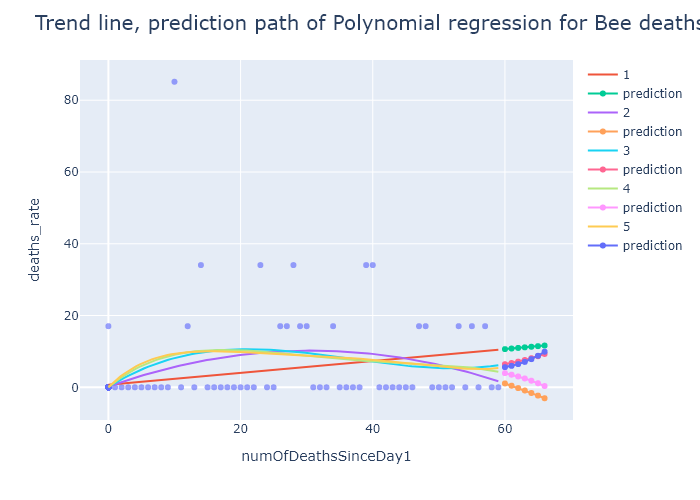

In [644]:
X_d3 = county_3_deaths.iloc[:,0].values.reshape(-1, 1) 
y_d3 = county_3_deaths.iloc[:,1].values.reshape(-1, 1) 
x_range = np.linspace(X_d3.min(), X_d3.max(), 100).reshape(-1, 1)
x_range1 = np.linspace(future_d_dates3.min(), future_d_dates3.max(), 7).reshape(-1, 1)

tx_d3 = px.scatter(county_3_deaths, x='numOfDeathsSinceDay1', y='deaths_rate', opacity=0.65)
for degree in [1, 2, 3, 4, 5]:
    poly = PolynomialFeatures(degree)
    poly.fit(X_d3)
    X_poly = poly.transform(X_d3)
    x_range_poly = poly.transform(x_range)
    X_poly1 = poly.fit_transform(future_d_dates3)
    x_range_poly1 = poly.fit_transform(x_range1)
    
    model = LinearRegression(fit_intercept=False)
    model.fit(X_poly, county_3_deaths['deaths_rate'])
    print("R square score of degree",degree,r2_score(y_d3,model.predict(X_poly)))
    y_poly = model.predict(x_range_poly)
    y_poly1 = model.predict(x_range_poly1)
    tx_d3.add_traces(go.Scatter(x=x_range.squeeze(), y=y_poly, name=degree))
    tx_d3.add_traces(go.Scatter(x=x_range1.squeeze(), y=y_poly1, name="prediction"))
#fig.show()
    print("RMSE of degree",degree,np.sqrt(metrics.mean_squared_error(y_d3,model.predict(X_poly))))
    tx_d3.update_layout(title_text="Trend line, prediction path of Polynomial regression for Bee deaths",
                  title_font_size=20)
tx_d3.write_image("../images1/tx_d3.png")
img_bytes = tx_d3.to_image(format="png")
Image(img_bytes)

##### Confidence interval

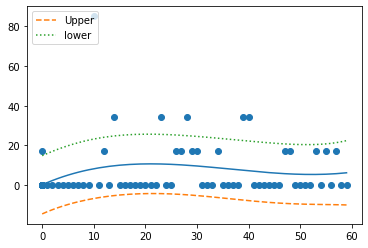

In [321]:
# We know from above that degree 3 fits better without overfitting
polynomial_features= PolynomialFeatures(degree=3)
xp = polynomial_features.fit_transform(X_d3)
xp.shape
model = sm.OLS(y_d3, xp).fit()
ypred = model.predict(xp) 

ypred.shape
from statsmodels.sandbox.regression.predstd import wls_prediction_std
_, upper,lower = wls_prediction_std(model)

plt.scatter(X_d3,y_d3)
plt.plot(X_d3,ypred)
plt.plot()
plt.plot(X_d3,upper,'--',label="Upper") # confid. intrvl
plt.plot(X_d3,lower,':',label="lower")
plt.legend(loc='upper left')

##### Polynomial and linear regression for Moore county deaths

R square score of degree 1 0.0019249023800764764
RMSE of degree 1 5.365181900865187
R square score of degree 2 0.0028353998753659626
RMSE of degree 2 5.362734139525031
R square score of degree 3 0.01488087440279895
RMSE of degree 3 5.330245550273592
R square score of degree 4 0.10925676719516042
RMSE of degree 4 5.068495983745137
R square score of degree 5 0.1213298953553239
RMSE of degree 5 5.034029614762996


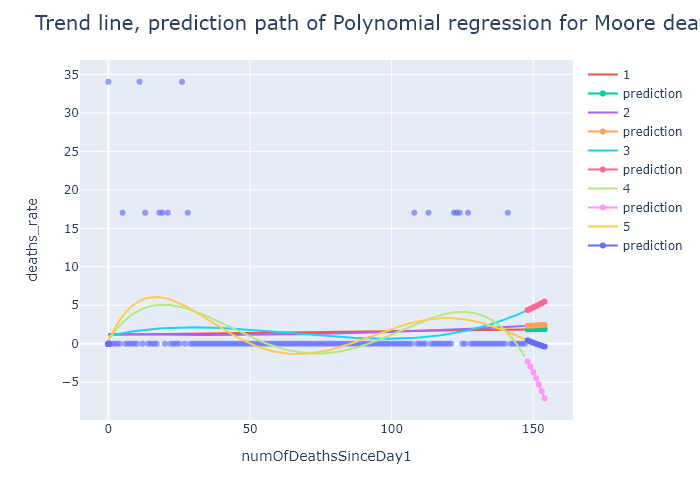

In [645]:
X_d4 = county_4_deaths.iloc[:,0].values.reshape(-1, 1) 
y_d4 = county_4_deaths.iloc[:,1].values.reshape(-1, 1) 
x_range = np.linspace(X_d4.min(), X_d4.max(), 100).reshape(-1, 1)
x_range1 = np.linspace(future_d_dates4.min(), future_d_dates4.max(), 7).reshape(-1, 1)

tx_d4 = px.scatter(county_4_deaths, x='numOfDeathsSinceDay1', y='deaths_rate', opacity=0.65)
for degree in [1, 2, 3, 4, 5]:
    poly = PolynomialFeatures(degree)
    poly.fit(X_d4)
    X_poly = poly.transform(X_d4)
    x_range_poly = poly.transform(x_range)
    X_poly1 = poly.fit_transform(future_d_dates4)
    x_range_poly1 = poly.fit_transform(x_range1)
    
    model = LinearRegression(fit_intercept=False)
    model.fit(X_poly, county_4_deaths['deaths_rate'])
    print("R square score of degree",degree,r2_score(y_d4,model.predict(X_poly)))
    y_poly = model.predict(x_range_poly)
    y_poly1 = model.predict(x_range_poly1)
    tx_d4.add_traces(go.Scatter(x=x_range.squeeze(), y=y_poly, name=degree))
    tx_d4.add_traces(go.Scatter(x=x_range1.squeeze(), y=y_poly1, name="prediction"))
#fig.show()
    print("RMSE of degree",degree,np.sqrt(metrics.mean_squared_error(y_d4,model.predict(X_poly))))
    tx_d4.update_layout(title_text="Trend line, prediction path of Polynomial regression for Moore deaths",
                  title_font_size=20)
tx_d4.write_image("../images1/tx_d4.png")
img_bytes = tx_d4.to_image(format="png")
Image(img_bytes)

##### Confidence interval

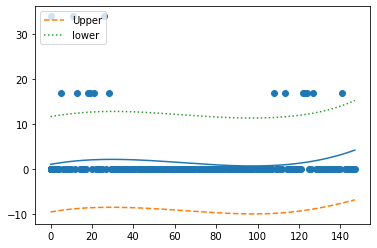

In [324]:
# We know from above that degree 3 fits better without overfitting
polynomial_features= PolynomialFeatures(degree=3)
xp = polynomial_features.fit_transform(X_d4)
xp.shape
model = sm.OLS(y_d4, xp).fit()
ypred = model.predict(xp) 

ypred.shape
from statsmodels.sandbox.regression.predstd import wls_prediction_std
_, upper,lower = wls_prediction_std(model)

plt.scatter(X_d4,y_d4)
plt.plot(X_d4,ypred)
plt.plot()
plt.plot(X_d4,upper,'--',label="Upper") # confid. intrvl
plt.plot(X_d4,lower,':',label="lower")
plt.legend(loc='upper left')

##### Polynomial regression for Hale county deaths

R square score of degree 1 0.10244700451900746
RMSE of degree 1 10.955698816607159
R square score of degree 2 0.10330344501632016
RMSE of degree 2 10.950470633124674
R square score of degree 3 0.13178449013964022
RMSE of degree 3 10.775161896188404
R square score of degree 4 0.15190834608041992
RMSE of degree 4 10.64955421678911
R square score of degree 5 0.15246974706522864
RMSE of degree 5 10.646028854918093


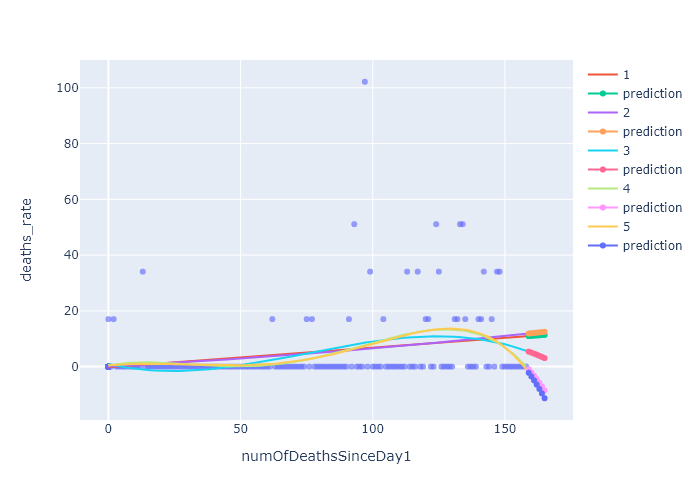

In [646]:
X_d5 = county_5_deaths.iloc[:,0].values.reshape(-1, 1) 
y_d5 = county_5_deaths.iloc[:,1].values.reshape(-1, 1)
x_range = np.linspace(X_d5.min(), X_d5.max(), 100).reshape(-1, 1)
x_range1 = np.linspace(future_d_dates5.min(), future_d_dates5.max(), 7).reshape(-1, 1)

tx_d5 = px.scatter(county_5_deaths, x='numOfDeathsSinceDay1', y=county_5_deaths['deaths_rate'], opacity=0.65)
for degree in [1, 2, 3, 4, 5]:
    poly = PolynomialFeatures(degree)
    poly.fit(X_d5)
    X_poly = poly.transform(X_d5)
    x_range_poly = poly.transform(x_range)
    X_poly1 = poly.fit_transform(future_d_dates5)
    x_range_poly1 = poly.fit_transform(x_range1)
                                                
    model = LinearRegression(fit_intercept=False)
    model.fit(X_poly, county_5_deaths['deaths_rate'])
    print("R square score of degree",degree,r2_score(y_d5,model.predict(X_poly)))
    y_poly = model.predict(x_range_poly)
    y_poly1 = model.predict(x_range_poly1)
    tx_d5.add_traces(go.Scatter(x=x_range.squeeze(), y=y_poly, name=degree))
    tx_d5.add_traces(go.Scatter(x=x_range1.squeeze(), y=y_poly1, name="prediction"))
#fig.show()
    print("RMSE of degree",degree,np.sqrt(metrics.mean_squared_error(y_d5,model.predict(X_poly))))
    tx_d3.update_layout(title_text="Trend line, prediction path of Polynomial regression for Hale cases",
                  title_font_size=20)
tx_d5.write_image("../images1/tx_d5.png")
img_bytes = tx_d5.to_image(format="png")
Image(img_bytes)

##### Confidence interval

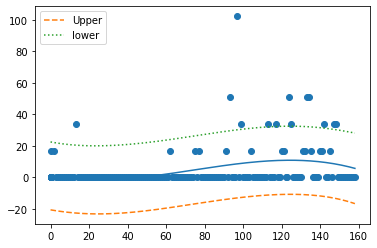

In [330]:
# We know from above that degree 3 fits better without overfitting
polynomial_features= PolynomialFeatures(degree=3)
xp = polynomial_features.fit_transform(X_d5)
xp.shape
model = sm.OLS(y_d5, xp).fit()
ypred = model.predict(xp) 

ypred.shape
from statsmodels.sandbox.regression.predstd import wls_prediction_std
_, upper,lower = wls_prediction_std(model)

plt.scatter(X_d5,y_d5)
plt.plot(X_d5,ypred)
plt.plot()
plt.plot(X_d5,upper,'--',label="Upper") # confid. intrvl
plt.plot(X_d5,lower,':',label="lower")
plt.legend(loc='upper left')

### Utilize the hospital data to calculate the point of no return for a state. Use percentage occupancy / utilization to see which states are close and what their trend looks like.

In [151]:
#Reading hospital data
hosp_data = pd.read_csv('../data/COVID_HospitalBeds_merged_df.csv')

In [152]:
hosp_data.head()

,State,countyFIPS,County Name,Date,Num of Cases,Num of Deaths,population,HOSPITAL_NAME,HOSPITAL_TYPE,HQ_CITY,HQ_ZIP_CODE,NUM_LICENSED_BEDS,NUM_STAFFED_BEDS,NUM_ICU_BEDS,ADULT_ICU_BEDS,PEDI_ICU_BEDS,BED_UTILIZATION,Potential_Increase_In_Bed_Capac,AVG_VENTILATOR_USAGE
0,AL,1001,autauga county,2020-01-22,0,0,55869,Prattville Baptist Hospital,Short Term Acute Care Hospital,Prattville,36067,85,55,6,6,0,0.623113,30,2
1,AL,1001,autauga county,2020-01-23,0,0,55869,Prattville Baptist Hospital,Short Term Acute Care Hospital,Prattville,36067,85,55,6,6,0,0.623113,30,2
2,AL,1001,autauga county,2020-01-24,0,0,55869,Prattville Baptist Hospital,Short Term Acute Care Hospital,Prattville,36067,85,55,6,6,0,0.623113,30,2
3,AL,1001,autauga county,2020-01-25,0,0,55869,Prattville Baptist Hospital,Short Term Acute Care Hospital,Prattville,36067,85,55,6,6,0,0.623113,30,2
4,AL,1001,autauga county,2020-01-26,0,0,55869,Prattville Baptist Hospital,Short Term Acute Care Hospital,Prattville,36067,85,55,6,6,0,0.623113,30,2


In [253]:
#Choosing 4 states
hosp_tx=hosp_data[hosp_data['State'].isin(['TX','NC','FL','CA','PA'])]
#Getting the new cases and new deaths column
hosp_tx['Num of Cases Per Day'] = hosp_tx['Num of Cases'].diff()
hosp_tx['Num of Deaths Per Day'] = hosp_tx['Num of Deaths'].diff()
#Removing first date as there are 0 cases on 22nd Jan and the first one will be NaN
hosp_tx = hosp_tx[hosp_tx['Date'] != '2020-01-22']
#Removing the number of cases and deaths columns as we have new cases and deaths
hosp_tx.drop(['Num of Cases','Num of Deaths'], axis=1, inplace=True)
hosp_tx
#5-6 values are negative as the dataset has some values where the Number of cases and deaths decreased(dataset is faulty), 
#so converting them to zero
num = hosp_tx['Num of Cases Per Day']._get_numeric_data()
num[num < 0] = 0
num1 = hosp_tx['Num of Deaths Per Day']._get_numeric_data()
num1[num1 < 0] = 0

C:\Users\nikit\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\nikit\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [254]:
f={'Num of Cases Per Day':'sum','Num of Deaths Per Day':'sum','population':'sum','NUM_ICU_BEDS':'sum'}
hosp_tx_data = hosp_tx.groupby(["Date","State"]).agg(f).reset_index()
hosp_tx_data


,Date,State,Num of Cases Per Day,Num of Deaths Per Day,population,NUM_ICU_BEDS
0,2020-01-23,CA,0.0,0.0,1569622038,8652
1,2020-01-23,FL,0.0,0.0,259329338,6231
2,2020-01-23,NC,0.0,0.0,40592353,2648
3,2020-01-23,PA,0.0,0.0,139130329,3961
4,2020-01-23,TX,0.0,0.0,794411551,8719
...,...,...,...,...,...,...
1175,2020-09-14,CA,4985.0,82.0,1569622038,8652
1176,2020-09-14,FL,1699.0,36.0,259329338,6231
1177,2020-09-14,NC,786.0,8.0,40592353,2648
1178,2020-09-14,PA,1165.0,31.0,139130329,3961


In [255]:
#Choosing the last data row in ur dataset to get the total number of icu beds in each state
hosp = hosp_tx_data[hosp_tx_data["Date"].isin(["2020-09-14"])]

In [256]:
hosp

,Date,State,Num of Cases Per Day,Num of Deaths Per Day,population,NUM_ICU_BEDS
1175,2020-09-14,CA,4985.0,82.0,1569622038,8652
1176,2020-09-14,FL,1699.0,36.0,259329338,6231
1177,2020-09-14,NC,786.0,8.0,40592353,2648
1178,2020-09-14,PA,1165.0,31.0,139130329,3961
1179,2020-09-14,TX,2562.0,20.0,794411551,8719


#### Texas deaths vs ICU beds

In [185]:
#Choosing Texas state
state_data_tx_date=super_data[super_data['State'].isin(['TX'])]
#Getting the new cases and new deaths column
state_data_tx_date['Num of Cases Per Day'] = state_data_tx_date['Num of Cases'].diff()
state_data_tx_date['Num of Deaths Per Day'] = state_data_tx_date['Num of Deaths'].diff()
#Removing first date as there are 0 cases on 22nd state_data_ca_date and the first one will be NaN
state_data_tx_date = state_data_tx_date[state_data_tx_date['Date'] != '2020-01-22']
#Removing the number of cases and deaths columns as we have new cases and deaths
state_data_tx_date.drop(['Num of Cases','Num of Deaths'], axis=1, inplace=True)
#5-6 values are negative as the dataset has some values where the Number of cases and deaths decreased(dataset is faulty), 
#so converting them to zero
num = state_data_tx_date['Num of Cases Per Day']._get_numeric_data()
num[num < 0] = 0
num1 = state_data_tx_date['Num of Deaths Per Day']._get_numeric_data()
num1[num1 < 0] = 0
state_data_tx_date

C:\Users\nikit\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\nikit\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,State,countyFIPS,County Name,Date,population,Num of Cases Per Day,Num of Deaths Per Day
608617,TX,0,statewide unallocated,2020-01-23,0,0.0,0.0
608618,TX,0,statewide unallocated,2020-01-24,0,0.0,0.0
608619,TX,0,statewide unallocated,2020-01-25,0,0.0,0.0
608620,TX,0,statewide unallocated,2020-01-26,0,0.0,0.0
608621,TX,0,statewide unallocated,2020-01-27,0,0.0,0.0
...,...,...,...,...,...,...,...
669046,TX,48507,zavala county,2020-09-10,11840,2.0,0.0
669047,TX,48507,zavala county,2020-09-11,11840,1.0,1.0
669048,TX,48507,zavala county,2020-09-12,11840,7.0,0.0
669049,TX,48507,zavala county,2020-09-13,11840,0.0,0.0


In [186]:
f={'Num of Cases Per Day':'sum','Num of Deaths Per Day':'sum','population':'sum','State':'first'}
state_data_tx_date = state_data_tx_date.groupby("Date").agg(f).reset_index()
state_data_tx_date


,Date,Num of Cases Per Day,Num of Deaths Per Day,population,State
0,2020-01-23,0.0,0.0,28995881,TX
1,2020-01-24,0.0,0.0,28995881,TX
2,2020-01-25,0.0,0.0,28995881,TX
3,2020-01-26,0.0,0.0,28995881,TX
4,2020-01-27,0.0,0.0,28995881,TX
...,...,...,...,...,...
231,2020-09-10,4017.0,161.0,28995881,TX
232,2020-09-11,3508.0,144.0,28995881,TX
233,2020-09-12,4431.0,147.0,28995881,TX
234,2020-09-13,3502.0,47.0,28995881,TX


In [187]:
first_death_index= state_data_tx_date['Num of Deaths Per Day'].ne(0).idxmax() 
numOfDeathsSinceDay1=[]
counter=1
for i,index in enumerate(range(len(state_data_tx_date))):
    if i<=first_death_index:
        numOfDeathsSinceDay1.insert(index, 0) 
    else:
        numOfDeathsSinceDay1.insert(index, counter) 
        counter = counter+1
        
#print(numOfCasesSinceDay1)   
state_data_tx_date.insert(2, "numOfDeathsSinceDay1", numOfDeathsSinceDay1)
state_data_tx_date.tail()

,Date,Num of Cases Per Day,numOfDeathsSinceDay1,Num of Deaths Per Day,population,State
231,2020-09-10,4017.0,178,161.0,28995881,TX
232,2020-09-11,3508.0,179,144.0,28995881,TX
233,2020-09-12,4431.0,180,147.0,28995881,TX
234,2020-09-13,3502.0,181,47.0,28995881,TX
235,2020-09-14,2568.0,182,21.0,28995881,TX


In [188]:
tx_deaths = state_data_tx_date[['numOfDeathsSinceDay1','Num of Deaths Per Day']]

In [189]:
future_dates_tx = np.arange(183,213).reshape(-1,1)


R-square of state deaths: 1 0.31807891821027634
RMSE of degree 1 90.40380504636879
R-square of state deaths: 2 0.33013744023536173
RMSE of degree 2 89.60092722457401
R-square of state deaths: 3 0.3561712773689837
RMSE of degree 3 87.84252792798065
R-square of state deaths: 4 0.44046784900021896
RMSE of degree 4 81.89024581420014
R-square of state deaths: 5 0.4487219177051206
RMSE of degree 5 81.28399017016707


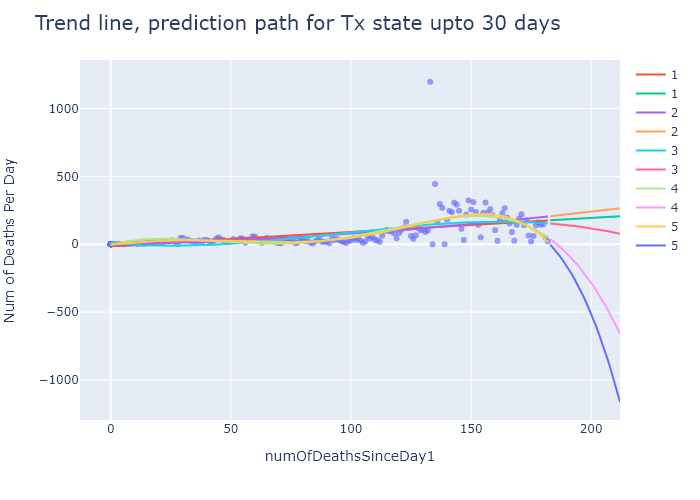

In [331]:
X_d = tx_deaths.numOfDeathsSinceDay1.values.reshape(-1, 1)
y_d = tx_deaths['Num of Deaths Per Day'].values.reshape(-1, 1)
x_range = np.linspace(X_d.min(), X_d.max(), 235).reshape(-1, 1)
x_range1 = np.linspace(future_dates_tx.min(), future_dates_tx.max(), 30).reshape(-1, 1)

tx_de = px.scatter(tx_deaths, x='numOfDeathsSinceDay1', y=tx_deaths['Num of Deaths Per Day'], opacity=0.65)
ally4=[]
for degree in [1, 2, 3, 4, 5]:
    poly = PolynomialFeatures(degree)
    poly.fit(X_d)
    X_poly = poly.fit_transform(X_d)
    x_range_poly = poly.fit_transform(x_range)
    X_poly1 = poly.fit_transform(future_dates_tx)
    x_range_poly1= poly.fit_transform(x_range1)
    
    model = LinearRegression()
    model.fit(X_poly, tx_deaths['Num of Deaths Per Day'])
    y_poly = model.predict(x_range_poly)
    y_poly1 = model.predict(X_poly1)
    
    print("R-square of state deaths:", degree, r2_score(y_d,model.predict(X_poly)))
    tx_de.add_traces(go.Scatter(x=x_range.squeeze(), y=y_poly, name=degree))
    tx_de.add_traces(go.Scatter(x=x_range1.squeeze(), y=y_poly1, name=degree))
    ally4.append(y_poly1)
#fig.show()
    print("RMSE of degree",degree,np.sqrt(metrics.mean_squared_error(y_d,model.predict(X_poly))))
    tx_de.update_layout(title_text="Trend line, prediction path for Tx state upto 30 days",
                  title_font_size=20)
tx_de.write_image("../images1/tx_de.png")
img_bytes = tx_de.to_image(format="png")
Image(img_bytes)

#### California deaths vs icu beds

In [175]:
#Choosing California state
state_data_ca_date=super_data[super_data['State'].isin(['CA'])]
#Getting the new cases and new deaths column
state_data_ca_date['Num of Cases Per Day'] = state_data_ca_date['Num of Cases'].diff()
state_data_ca_date['Num of Deaths Per Day'] = state_data_ca_date['Num of Deaths'].diff()
#Removing first date as there are 0 cases on 22nd state_data_ca_date and the first one will be NaN
state_data_ca_date = state_data_ca_date[state_data_ca_date['Date'] != '2020-01-22']
#Removing the number of cases and deaths columns as we have new cases and deaths
state_data_ca_date.drop(['Num of Cases','Num of Deaths'], axis=1, inplace=True)
#5-6 values are negative as the dataset has some values where the Number of cases and deaths decreased(dataset is faulty), 
#so converting them to zero
num = state_data_ca_date['Num of Cases Per Day']._get_numeric_data()
num[num < 0] = 0
num1 = state_data_ca_date['Num of Deaths Per Day']._get_numeric_data()
num1[num1 < 0] = 0
state_data_ca_date

C:\Users\nikit\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\nikit\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,State,countyFIPS,County Name,Date,population,Num of Cases Per Day,Num of Deaths Per Day
45268,CA,0,statewide unallocated,2020-01-23,0,0.0,0.0
45269,CA,0,statewide unallocated,2020-01-24,0,0.0,0.0
45270,CA,0,statewide unallocated,2020-01-25,0,0.0,0.0
45271,CA,0,statewide unallocated,2020-01-26,0,0.0,0.0
45272,CA,0,statewide unallocated,2020-01-27,0,0.0,0.0
...,...,...,...,...,...,...,...
59482,CA,6115,yuba county,2020-09-10,78668,0.0,0.0
59483,CA,6115,yuba county,2020-09-11,78668,20.0,0.0
59484,CA,6115,yuba county,2020-09-12,78668,0.0,0.0
59485,CA,6115,yuba county,2020-09-13,78668,0.0,0.0


In [176]:
f={'Num of Cases Per Day':'sum','Num of Deaths Per Day':'sum','population':'sum','State':'first'}
state_data_ca_date = state_data_ca_date.groupby("Date").agg(f).reset_index()
state_data_ca_date


,Date,Num of Cases Per Day,Num of Deaths Per Day,population,State
0,2020-01-23,0.0,0.0,39512223,CA
1,2020-01-24,0.0,0.0,39512223,CA
2,2020-01-25,0.0,0.0,39512223,CA
3,2020-01-26,2.0,0.0,39512223,CA
4,2020-01-27,1.0,0.0,39512223,CA
...,...,...,...,...,...
231,2020-09-10,2253.0,59.0,39512223,CA
232,2020-09-11,5433.0,212.0,39512223,CA
233,2020-09-12,3009.0,72.0,39512223,CA
234,2020-09-13,1986.0,52.0,39512223,CA


In [177]:
first_death_index= state_data_ca_date['Num of Deaths Per Day'].ne(0).idxmax() 
numOfDeathsSinceDay1=[]
counter=1
for i,index in enumerate(range(len(state_data_ca_date))):
    if i<=first_death_index:
        numOfDeathsSinceDay1.insert(index, 0) 
    else:
        numOfDeathsSinceDay1.insert(index, counter) 
        counter = counter+1
        
#print(numOfCasesSinceDay1)   
state_data_ca_date.insert(2, "numOfDeathsSinceDay1", numOfDeathsSinceDay1)
state_data_ca_date.tail()

,Date,Num of Cases Per Day,numOfDeathsSinceDay1,Num of Deaths Per Day,population,State
231,2020-09-10,2253.0,217,59.0,39512223,CA
232,2020-09-11,5433.0,218,212.0,39512223,CA
233,2020-09-12,3009.0,219,72.0,39512223,CA
234,2020-09-13,1986.0,220,52.0,39512223,CA
235,2020-09-14,4985.0,221,82.0,39512223,CA


In [178]:
ca_deaths = state_data_ca_date[['numOfDeathsSinceDay1','Num of Deaths Per Day']]

In [179]:
future_dates_ca = np.arange(222,252).reshape(-1,1)


R-square of state deaths: 1 0.5335949398079076
RMSE of degree 1 38.34620347411378
R-square of state deaths: 2 0.5434054148053824
RMSE of degree 2 37.94076855636597
R-square of state deaths: 3 0.5466889221303294
RMSE of degree 3 37.80410073851409
R-square of state deaths: 4 0.5482976908034135
RMSE of degree 4 37.736959087174405
R-square of state deaths: 5 0.598694654315848
RMSE of degree 5 35.56953748688639


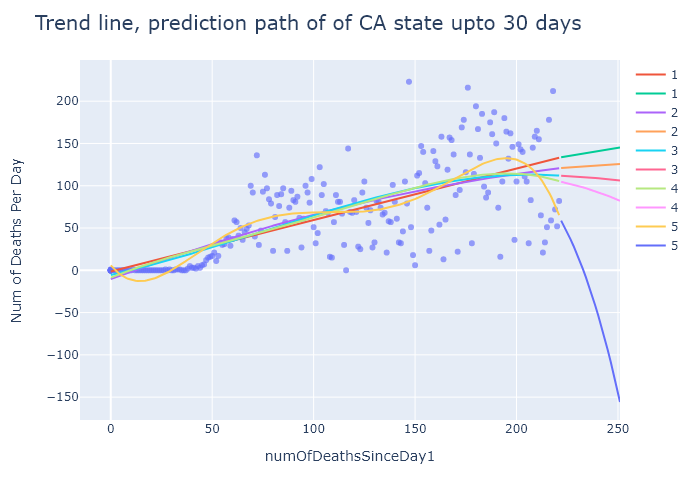

In [332]:
X_d = ca_deaths.numOfDeathsSinceDay1.values.reshape(-1, 1)
y_d = ca_deaths['Num of Deaths Per Day'].values.reshape(-1, 1)
x_range = np.linspace(X_d.min(), X_d.max(), 235).reshape(-1, 1)
x_range1 = np.linspace(future_dates_ca.min(), future_dates_ca.max(), 20).reshape(-1, 1)

ca_de = px.scatter(ca_deaths, x='numOfDeathsSinceDay1', y=ca_deaths['Num of Deaths Per Day'], opacity=0.65)
ally2=[]
for degree in [1, 2, 3, 4, 5]:
    poly = PolynomialFeatures(degree)
    poly.fit(X_d)
    X_poly = poly.fit_transform(X_d)
    x_range_poly = poly.fit_transform(x_range)
    X_poly1 = poly.fit_transform(future_dates_ca)
    x_range_poly1= poly.fit_transform(x_range1)
    model = LinearRegression()
    model.fit(X_poly, ca_deaths['Num of Deaths Per Day'])
    y_poly = model.predict(x_range_poly)
    y_poly1 = model.predict(X_poly1)
    print("R-square of state deaths:", degree, r2_score(y_d,model.predict(X_poly)))
    ca_de.add_traces(go.Scatter(x=x_range.squeeze(), y=y_poly, name=degree))
    ca_de.add_traces(go.Scatter(x=x_range1.squeeze(), y=y_poly1, name=degree))
    ally2.append(y_poly1)
#fig.show()
    print("RMSE of degree",degree,np.sqrt(metrics.mean_squared_error(y_d,model.predict(X_poly))))
    ca_de.update_layout(title_text="Trend line, prediction path of of CA state upto 30 days",
                  title_font_size=20)
ca_de.write_image("../images1/ca_de.png")
img_bytes = ca_de.to_image(format="png")
Image(img_bytes)

#### NC deaths vs icu beds

In [193]:
#Choosing California state
state_data_nc_date=super_data[super_data['State'].isin(['NC'])]
#Getting the new cases and new deaths column
state_data_nc_date['Num of Cases Per Day'] = state_data_nc_date['Num of Cases'].diff()
state_data_nc_date['Num of Deaths Per Day'] = state_data_nc_date['Num of Deaths'].diff()
#Removing first date as there are 0 cases on 22nd state_data_ca_date and the first one will be NaN
state_data_nc_date = state_data_nc_date[state_data_nc_date['Date'] != '2020-01-22']
#Removing the number of cases and deaths columns as we have new cases and deaths
state_data_nc_date.drop(['Num of Cases','Num of Deaths'], axis=1, inplace=True)
#5-6 values are negative as the dataset has some values where the Number of cases and deaths decreased(dataset is faulty), 
#so converting them to zero
num = state_data_nc_date['Num of Cases Per Day']._get_numeric_data()
num[num < 0] = 0
num1 = state_data_nc_date['Num of Deaths Per Day']._get_numeric_data()
num1[num1 < 0] = 0
state_data_nc_date

C:\Users\nikit\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\nikit\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,State,countyFIPS,County Name,Date,population,Num of Cases Per Day,Num of Deaths Per Day
456226,NC,0,statewide unallocated,2020-01-23,0,0.0,0.0
456227,NC,0,statewide unallocated,2020-01-24,0,0.0,0.0
456228,NC,0,statewide unallocated,2020-01-25,0,0.0,0.0
456229,NC,0,statewide unallocated,2020-01-26,0,0.0,0.0
456230,NC,0,statewide unallocated,2020-01-27,0,0.0,0.0
...,...,...,...,...,...,...,...
480157,NC,37199,yancey county,2020-09-10,18069,2.0,0.0
480158,NC,37199,yancey county,2020-09-11,18069,2.0,0.0
480159,NC,37199,yancey county,2020-09-12,18069,1.0,0.0
480160,NC,37199,yancey county,2020-09-13,18069,1.0,0.0


In [194]:
f={'Num of Cases Per Day':'sum','Num of Deaths Per Day':'sum','population':'sum','State':'first'}
state_data_nc_date = state_data_nc_date.groupby("Date").agg(f).reset_index()
state_data_nc_date


,Date,Num of Cases Per Day,Num of Deaths Per Day,population,State
0,2020-01-23,0.0,0.0,10488084,NC
1,2020-01-24,0.0,0.0,10488084,NC
2,2020-01-25,0.0,0.0,10488084,NC
3,2020-01-26,0.0,0.0,10488084,NC
4,2020-01-27,0.0,0.0,10488084,NC
...,...,...,...,...,...
231,2020-09-10,1225.0,33.0,10488084,NC
232,2020-09-11,1532.0,33.0,10488084,NC
233,2020-09-12,1453.0,24.0,10488084,NC
234,2020-09-13,1193.0,5.0,10488084,NC


In [195]:
first_death_index= state_data_nc_date['Num of Deaths Per Day'].ne(0).idxmax() 
numOfDeathsSinceDay1=[]
counter=1
for i,index in enumerate(range(len(state_data_nc_date))):
    if i<=first_death_index:
        numOfDeathsSinceDay1.insert(index, 0) 
    else:
        numOfDeathsSinceDay1.insert(index, counter) 
        counter = counter+1
        
#print(numOfCasesSinceDay1)   
state_data_nc_date.insert(2, "numOfDeathsSinceDay1", numOfDeathsSinceDay1)
state_data_nc_date.tail()

,Date,Num of Cases Per Day,numOfDeathsSinceDay1,Num of Deaths Per Day,population,State
231,2020-09-10,1225.0,169,33.0,10488084,NC
232,2020-09-11,1532.0,170,33.0,10488084,NC
233,2020-09-12,1453.0,171,24.0,10488084,NC
234,2020-09-13,1193.0,172,5.0,10488084,NC
235,2020-09-14,841.0,173,8.0,10488084,NC


In [196]:
nc_deaths = state_data_nc_date[['numOfDeathsSinceDay1','Num of Deaths Per Day']]

In [197]:
future_dates_nc = np.arange(174,203).reshape(-1,1)


R-square of state deaths: 1 0.3253913251322168
RMSE of degree 1 12.339164174065571
R-square of state deaths: 2 0.3463236062012588
RMSE of degree 2 12.146221106408746
R-square of state deaths: 3 0.3603418204654696
RMSE of degree 3 12.015276259564475
R-square of state deaths: 4 0.39344061534675845
RMSE of degree 4 11.700285121379153
R-square of state deaths: 5 0.39621765598738623
RMSE of degree 5 11.673470399183188


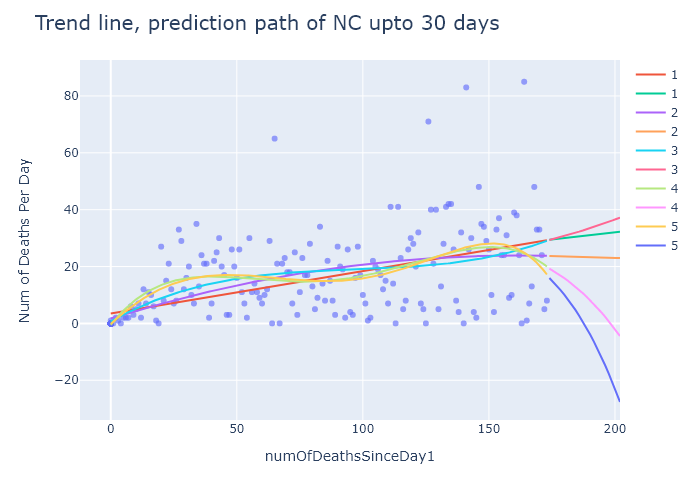

In [333]:
X_d = nc_deaths.numOfDeathsSinceDay1.values.reshape(-1, 1)
y_d= nc_deaths['Num of Deaths Per Day'].values.reshape(-1, 1)
x_range = np.linspace(X_d.min(), X_d.max(), 235).reshape(-1, 1)
x_range1 = np.linspace(future_dates_nc.min(), future_dates_nc.max(), 20).reshape(-1, 1)

nc_de = px.scatter(nc_deaths, x='numOfDeathsSinceDay1', y=nc_deaths['Num of Deaths Per Day'], opacity=0.65)
ally1=[]
for degree in [1, 2, 3, 4, 5]:
    poly = PolynomialFeatures(degree)
    poly.fit(X_d)
    X_poly = poly.fit_transform(X_d)
    x_range_poly = poly.fit_transform(x_range)
    X_poly1 = poly.fit_transform(future_dates_nc)
    x_range_poly1= poly.fit_transform(x_range1)
    model = LinearRegression()
    model.fit(X_poly, nc_deaths['Num of Deaths Per Day'])
    y_poly = model.predict(x_range_poly)
    y_poly1 = model.predict(X_poly1)
    print("R-square of state deaths:", degree, r2_score(y_d,model.predict(X_poly)))
    nc_de.add_traces(go.Scatter(x=x_range.squeeze(), y=y_poly, name=degree))
    nc_de.add_traces(go.Scatter(x=x_range1.squeeze(), y=y_poly1, name=degree))
    ally1.append(y_poly1)
#fig.show()
    print("RMSE of degree",degree,np.sqrt(metrics.mean_squared_error(y_d,model.predict(X_poly))))
    nc_de.update_layout(title_text="Trend line, prediction path of NC upto 30 days",
                  title_font_size=20)
nc_de.write_image("../images1/nc_de.png")
img_bytes = nc_de.to_image(format="png")
Image(img_bytes)

#### FL deaths vs ICU beds

In [200]:
#Choosing florida state
state_data_fl_date=super_data[super_data['State'].isin(['FL'])]
#Getting the new cases and new deaths column
state_data_fl_date['Num of Cases Per Day'] = state_data_fl_date['Num of Cases'].diff()
state_data_fl_date['Num of Deaths Per Day'] = state_data_fl_date['Num of Deaths'].diff()
#Removing first date as there are 0 cases on 22nd state_data_ca_date and the first one will be NaN
state_data_fl_date = state_data_fl_date[state_data_fl_date['Date'] != '2020-01-22']
#Removing the number of cases and deaths columns as we have new cases and deaths
state_data_fl_date.drop(['Num of Cases','Num of Deaths'], axis=1, inplace=True)
#5-6 values are negative as the dataset has some values where the Number of cases and deaths decreased(dataset is faulty), 
#so converting them to zero
num = state_data_fl_date['Num of Cases Per Day']._get_numeric_data()
num[num < 0] = 0
num1 = state_data_fl_date['Num of Deaths Per Day']._get_numeric_data()
num1[num1 < 0] = 0
state_data_fl_date

C:\Users\nikit\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\nikit\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,State,countyFIPS,County Name,Date,population,Num of Cases Per Day,Num of Deaths Per Day
78211,FL,0,statewide unallocated,2020-01-23,0,0.0,0.0
78212,FL,0,statewide unallocated,2020-01-24,0,0.0,0.0
78213,FL,0,statewide unallocated,2020-01-25,0,0.0,0.0
78214,FL,0,statewide unallocated,2020-01-26,0,0.0,0.0
78215,FL,0,statewide unallocated,2020-01-27,0,0.0,0.0
...,...,...,...,...,...,...,...
94321,FL,12133,washington county,2020-09-10,25473,8.0,1.0
94322,FL,12133,washington county,2020-09-11,25473,2.0,0.0
94323,FL,12133,washington county,2020-09-12,25473,6.0,0.0
94324,FL,12133,washington county,2020-09-13,25473,0.0,0.0


In [201]:
f={'Num of Cases Per Day':'sum','Num of Deaths Per Day':'sum','population':'sum','State':'first'}
state_data_fl_date = state_data_fl_date.groupby("Date").agg(f).reset_index()
state_data_fl_date


,Date,Num of Cases Per Day,Num of Deaths Per Day,population,State
0,2020-01-23,0.0,0.0,21477737,FL
1,2020-01-24,0.0,0.0,21477737,FL
2,2020-01-25,0.0,0.0,21477737,FL
3,2020-01-26,0.0,0.0,21477737,FL
4,2020-01-27,0.0,0.0,21477737,FL
...,...,...,...,...,...
231,2020-09-10,2583.0,212.0,21477737,FL
232,2020-09-11,3746.0,174.0,21477737,FL
233,2020-09-12,3189.0,95.0,21477737,FL
234,2020-09-13,2422.0,10.0,21477737,FL


In [202]:
first_death_index= state_data_fl_date['Num of Deaths Per Day'].ne(0).idxmax() 
numOfDeathsSinceDay1=[]
counter=1
for i,index in enumerate(range(len(state_data_fl_date))):
    if i<=first_death_index:
        numOfDeathsSinceDay1.insert(index, 0) 
    else:
        numOfDeathsSinceDay1.insert(index, counter) 
        counter = counter+1
        
#print(numOfCasesSinceDay1)   
state_data_fl_date.insert(2, "numOfDeathsSinceDay1", numOfDeathsSinceDay1)
state_data_fl_date.tail()

fl_deaths = state_data_fl_date[['numOfDeathsSinceDay1','Num of Deaths Per Day']]

In [203]:
fl_deaths.tail()

,numOfDeathsSinceDay1,Num of Deaths Per Day
231,188,212.0
232,189,174.0
233,190,95.0
234,191,10.0
235,192,36.0


In [204]:
future_dates_fl = np.arange(193,223).reshape(-1,1)


R-square of state deaths: 1 0.4927482043795651
RMSE of degree 1 46.28448016309935
R-square of state deaths: 2 0.49623995037511803
RMSE of degree 2 46.12490188839036
R-square of state deaths: 3 0.506738277779413
RMSE of degree 3 45.641751417724656
R-square of state deaths: 4 0.5967069111655365
RMSE of degree 4 41.26995389176961
R-square of state deaths: 5 0.6138903215840745
RMSE of degree 5 40.38117370565879


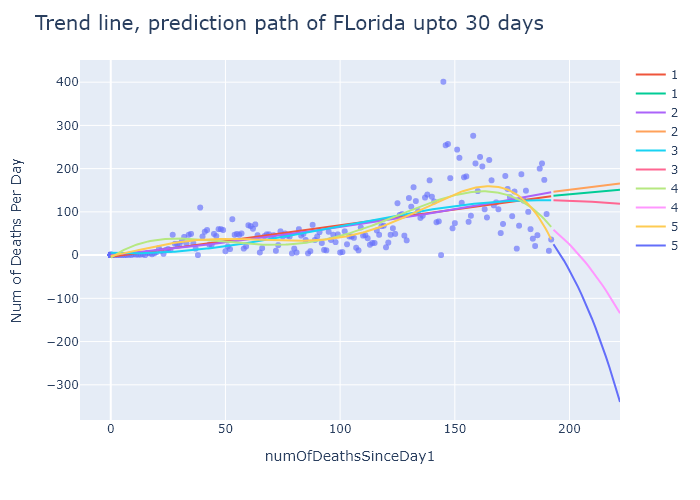

In [334]:
X_d = fl_deaths.numOfDeathsSinceDay1.values.reshape(-1, 1)
y_d= fl_deaths['Num of Deaths Per Day'].values.reshape(-1, 1)
x_range = np.linspace(X_d.min(), X_d.max(), 235).reshape(-1, 1)
x_range1 = np.linspace(future_dates_fl.min(), future_dates_fl.max(), 20).reshape(-1, 1)

fl_de = px.scatter(fl_deaths, x='numOfDeathsSinceDay1', y=fl_deaths['Num of Deaths Per Day'], opacity=0.65)
ally = []
for degree in [1, 2, 3, 4, 5]:
    poly = PolynomialFeatures(degree)
    poly.fit(X_d)
    X_poly = poly.fit_transform(X_d)
    x_range_poly = poly.fit_transform(x_range)
    X_poly1 = poly.fit_transform(future_dates_fl)
    x_range_poly1= poly.fit_transform(x_range1)
    model = LinearRegression()
    model.fit(X_poly, fl_deaths['Num of Deaths Per Day'])
    y_poly = model.predict(x_range_poly)
    y_poly1 = model.predict(X_poly1)
    print("R-square of state deaths:", degree, r2_score(y_d,model.predict(X_poly)))
    fl_de.add_traces(go.Scatter(x=x_range.squeeze(), y=y_poly, name=degree))
    fl_de.add_traces(go.Scatter(x=x_range1.squeeze(), y=y_poly1, name=degree))
    ally.append(y_poly1)
#fig.show()
    print("RMSE of degree",degree,np.sqrt(metrics.mean_squared_error(y_d,model.predict(X_poly))))
    fl_de.update_layout(title_text="Trend line, prediction path of FLorida upto 30 days",
                  title_font_size=20)
    
fl_de.write_image("../images1/fl_de.png")
img_bytes = fl_de.to_image(format="png")
Image(img_bytes)

#### PA beds vs ICU beds

In [207]:
#Choosing florida state
state_data_pa_date=super_data[super_data['State'].isin(['PA'])]
#Getting the new cases and new deaths column
state_data_pa_date['Num of Cases Per Day'] = state_data_pa_date['Num of Cases'].diff()
state_data_pa_date['Num of Deaths Per Day'] = state_data_pa_date['Num of Deaths'].diff()
#Removing first date as there are 0 cases on 22nd state_data_ca_date and the first one will be NaN
state_data_pa_date = state_data_pa_date[state_data_pa_date['Date'] != '2020-01-22']
#Removing the number of cases and deaths columns as we have new cases and deaths
state_data_pa_date.drop(['Num of Cases','Num of Deaths'], axis=1, inplace=True)
#5-6 values are negative as the dataset has some values where the Number of cases and deaths decreased(dataset is faulty), 
#so converting them to zero
num = state_data_pa_date['Num of Cases Per Day']._get_numeric_data()
num[num < 0] = 0
num1 = state_data_pa_date['Num of Deaths Per Day']._get_numeric_data()
num1[num1 < 0] = 0
state_data_pa_date

C:\Users\nikit\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\nikit\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,State,countyFIPS,County Name,Date,population,Num of Cases Per Day,Num of Deaths Per Day
541309,PA,0,statewide unallocated,2020-01-23,0,0.0,0.0
541310,PA,0,statewide unallocated,2020-01-24,0,0.0,0.0
541311,PA,0,statewide unallocated,2020-01-25,0,0.0,0.0
541312,PA,0,statewide unallocated,2020-01-26,0,0.0,0.0
541313,PA,0,statewide unallocated,2020-01-27,0,0.0,0.0
...,...,...,...,...,...,...,...
557419,PA,42133,york county,2020-09-10,449058,40.0,1.0
557420,PA,42133,york county,2020-09-11,449058,66.0,0.0
557421,PA,42133,york county,2020-09-12,449058,129.0,0.0
557422,PA,42133,york county,2020-09-13,449058,0.0,0.0


In [208]:
f={'Num of Cases Per Day':'sum','Num of Deaths Per Day':'sum','population':'sum','State':'first'}
state_data_pa_date = state_data_pa_date.groupby("Date").agg(f).reset_index()
state_data_pa_date


,Date,Num of Cases Per Day,Num of Deaths Per Day,population,State
0,2020-01-23,0.0,0.0,12801989,PA
1,2020-01-24,0.0,0.0,12801989,PA
2,2020-01-25,0.0,0.0,12801989,PA
3,2020-01-26,0.0,0.0,12801989,PA
4,2020-01-27,0.0,0.0,12801989,PA
...,...,...,...,...,...
231,2020-09-10,590.0,15.0,12801989,PA
232,2020-09-11,1008.0,17.0,12801989,PA
233,2020-09-12,919.0,0.0,12801989,PA
234,2020-09-13,75.0,0.0,12801989,PA


In [209]:
first_death_index= state_data_pa_date['Num of Deaths Per Day'].ne(0).idxmax() 
numOfDeathsSinceDay1=[]
counter=1
for i,index in enumerate(range(len(state_data_pa_date))):
    if i<=first_death_index:
        numOfDeathsSinceDay1.insert(index, 0) 
    else:
        numOfDeathsSinceDay1.insert(index, counter) 
        counter = counter+1
        
#print(numOfCasesSinceDay1)   
state_data_pa_date.insert(2, "numOfDeathsSinceDay1", numOfDeathsSinceDay1)
state_data_pa_date.tail()

pa_deaths = state_data_pa_date[['numOfDeathsSinceDay1','Num of Deaths Per Day']]
pa_deaths

,numOfDeathsSinceDay1,Num of Deaths Per Day
0,0,0.0
1,0,0.0
2,0,0.0
3,0,0.0
4,0,0.0
...,...,...
231,176,15.0
232,177,17.0
233,178,0.0
234,179,0.0


In [210]:
future_dates_pa = np.arange(181,211).reshape(-1,1)


R-square of state deaths: 1 0.0003461289572839199
RMSE of degree 1 64.4608660421629
R-square of state deaths: 2 0.1554719397878751
RMSE of degree 2 59.24863536521738
R-square of state deaths: 3 0.30906672818978176
RMSE of degree 3 53.5906917895491
R-square of state deaths: 4 0.3176130711529638
RMSE of degree 4 53.258221510889236
R-square of state deaths: 5 0.3454393165417936
RMSE of degree 5 52.16104311296989


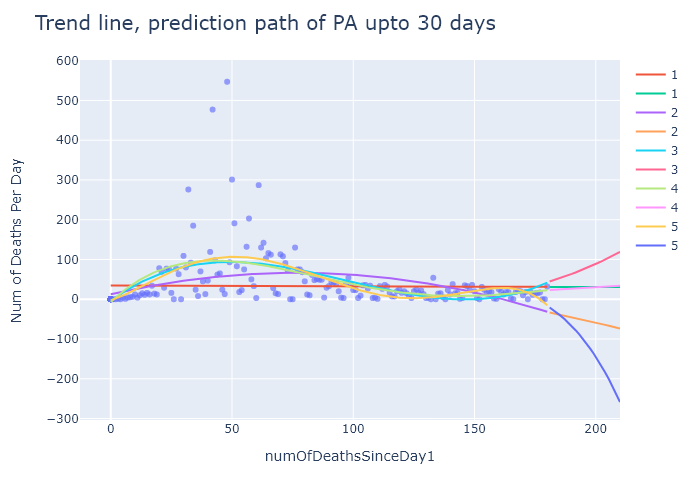

In [335]:
X_d = pa_deaths.numOfDeathsSinceDay1.values.reshape(-1, 1)
y_d= pa_deaths['Num of Deaths Per Day'].values.reshape(-1, 1)
x_range = np.linspace(X_d.min(), X_d.max(), 235).reshape(-1, 1)
x_range1 = np.linspace(future_dates_pa.min(), future_dates_pa.max(), 20).reshape(-1, 1)

pa_de = px.scatter(pa_deaths, x='numOfDeathsSinceDay1', y=pa_deaths['Num of Deaths Per Day'], opacity=0.65)
ally3 = []
for degree in [1, 2, 3, 4, 5]:
    poly = PolynomialFeatures(degree)
    poly.fit(X_d)
    X_poly = poly.fit_transform(X_d)
    x_range_poly = poly.fit_transform(x_range)
    X_poly1 = poly.fit_transform(future_dates_pa)
    x_range_poly1= poly.fit_transform(x_range1)
    model = LinearRegression()
    model.fit(X_poly, pa_deaths['Num of Deaths Per Day'])
    y_poly = model.predict(x_range_poly)
    y_poly1 = model.predict(X_poly1)
    print("R-square of state deaths:", degree, r2_score(y_d,model.predict(X_poly)))
    pa_de.add_traces(go.Scatter(x=x_range.squeeze(), y=y_poly, name=degree))
    pa_de.add_traces(go.Scatter(x=x_range1.squeeze(), y=y_poly1, name=degree))
    ally3.append(y_poly1)
#fig.show()
    print("RMSE of degree",degree,np.sqrt(metrics.mean_squared_error(y_d,model.predict(X_poly))))
    pa_de.update_layout(title_text="Trend line, prediction path of PA upto 30 days",
                  title_font_size=20)
    
pa_de.write_image("../images1/pa_de.png")
img_bytes = pa_de.to_image(format="png")
Image(img_bytes)

In [336]:
print("Total deaths for next month in Florida :", ally[2])
print("Total deaths for next month in NC :", ally1[2])      
print("Total deaths for next month in CA :", ally2[2])
print("Total deaths for next month in PA :", ally3[2])
print("Total deaths for next month in Texas :", ally4[2])


Total deaths for next month in Florida : [126.65191719 126.48587768 126.29436272 126.07710624 125.8338422
 125.56430455 125.26822724 124.94534421 124.59538942 124.21809681
 123.81320034 123.38043395 122.91953159 122.43022722 121.91225478
 121.36534822 120.78924149 120.18366855 119.54836333 118.8830598
 118.18749189 117.46139356 116.70449876 115.91654144 115.09725554
 114.24637502 113.36363383 112.44876591 111.50150522 110.5215857 ]
Total deaths for next month in NC : [29.36366054 29.70147107 30.04711792 30.40070095 30.76232004 31.13207508
 31.51006594 31.89639251 32.29115466 32.69445227 33.10638523 33.5270534
 33.95655668 34.39499494 34.84246807 35.29907593 35.76491841 36.24009539
 36.72470676 37.21885238 37.72263214 38.23614592 38.7594936  39.29277506
 39.83609017 40.38953882 40.95322089 41.52723625 42.11168479]
Total deaths for next month in CA : [111.93998647 111.75580092 111.55883214 111.34899465 111.12620298
 110.89037164 110.64141515 110.37924802 110.10378478 109.81493994
 109.51

In [215]:
hosp

,Date,State,Num of Cases Per Day,Num of Deaths Per Day,population,NUM_ICU_BEDS
1175,2020-09-14,CA,4985.0,82.0,1569622038,8652
1176,2020-09-14,FL,1699.0,36.0,259329338,6231
1177,2020-09-14,NC,786.0,8.0,40592353,2648
1178,2020-09-14,PA,1165.0,31.0,139130329,3961
1179,2020-09-14,TX,2562.0,20.0,794411551,8719


##### We can see from the above data, According to my prediction among 5 states using polynomial regression with degree 3 on state deaths, the graph looks well fitted on degree 3 for all states.

#### But no state until next month would reach its point of no return.


#### Utilize decision tree, random forest, and ARIMA (https://machinelearningmastery.com/arima-for-time-series-forecasting-with-python/) based models to compare and contrast the performance of each. X-variable is the previous weeks data, Y-variable is current week data. So you are predicting one week in advance. Calculate RMSE error. This is just based on number of cases.

##### Decision tree regressor

In [222]:
#Selecting X and y variables
X = state_cases.iloc[:,0].values.reshape(-1, 1) 
y = state_cases.iloc[:,1].values.reshape(-1, 1) 

In [232]:
#Splitting into train and test
x_train = X[:229]
x_test = X[229:]
y_train = y[:229]
y_test = y[229:]

In [224]:
#Decision tree object
regressor = DecisionTreeRegressor()  
  
# fit the regressor with X and Y data 
regressor.fit(x_train, y_train) 

DecisionTreeRegressor()

In [225]:
#Predicting 
y_pred = regressor.predict(x_test)

In [226]:
mse = metrics.mean_squared_error(y_test,y_pred)
mse


3407695.1428571427

In [228]:
rmse=np.sqrt(mse)
print("RMSE score of Decision tree", rmse)

RMSE score of Decision tree 1845.9943507110586


##### Random forest regressor

In [233]:
rf = RandomForestRegressor(n_estimators = 1000, random_state = 42)
# Train the model on training data
rf.fit(x_train, y_train)

C:\Users\nikit\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().



RandomForestRegressor(n_estimators=1000, random_state=42)

In [234]:
# Use the forest's predict method on the test data
predictions = rf.predict(x_test)
# Calculate the absolute errors
errors = abs(predictions - y_test)
# # Print out the mean absolute error (mae)
print('Mean Absolute Error:', round(np.mean(errors), 2), 'degrees.')


Mean Absolute Error: 1226.9 degrees.


In [235]:
mse = metrics.mean_squared_error(y_test,predictions)
mse

1889145.1756261424

In [238]:
rmse=np.sqrt(mse)
print("RMSE of Random forest regressor: ", rmse)

RMSE of Random forest regressor:  1374.4617767061195


#### ARIMA

In [414]:
arima_data = state_data_tx_date[['Date','Num of Cases Per Day']]

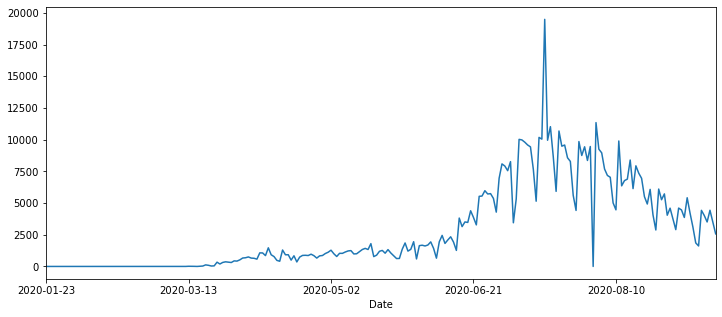

In [415]:
#Plotting the cases and dates
arima_data = arima_data.set_index('Date')
arima_data['Num of Cases Per Day'].plot(figsize=(12,5))

In [420]:
# y variable as number of cases
y = arima_data.iloc[:,0].values.reshape(-1, 1) 


In [421]:
#Training on first part of data and testing on last week
y_train = y[:229]
y_test = y[229:]

In [647]:
## pmdarima library not loading giving multiple errors, so trying different orders of p,d,q values

In [424]:
from statsmodels.tsa.stattools import acf

# Create Training and Test
train = arima_data['Num of Cases Per Day'][:229]
test = arima_data['Num of Cases Per Day'][229:]

In [425]:
test.shape

(7,)

C:\Users\nikit\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\nikit\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



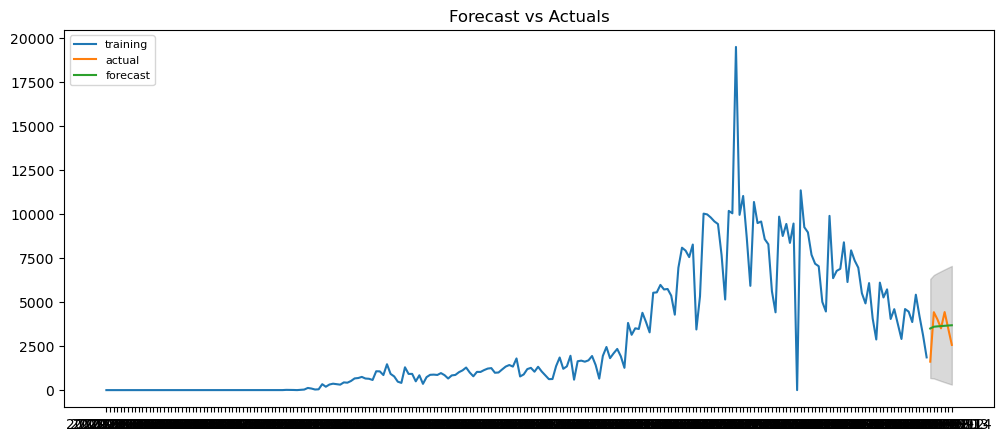

In [426]:
# Build Model
# model = ARIMA(train, order=(3,2,1))  
model = ARIMA(train, order=(1, 1, 1))  
fitted = model.fit(disp=-1)  

# Forecast
fc, se, conf = fitted.forecast(7, alpha=0.05)  # 95% conf

# Make as pandas series
fc_series = pd.Series(fc, index=test.index)
lower_series = pd.Series(conf[:, 0], index=test.index)
upper_series = pd.Series(conf[:, 1], index=test.index)

# Plot
plt.figure(figsize=(12,5), dpi=100)
plt.plot(train, label='training')
plt.plot(test, label='actual')
plt.plot(fc_series, label='forecast')
plt.fill_between(lower_series.index, lower_series, upper_series, 
                 color='k', alpha=.15)
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()

C:\Users\nikit\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\nikit\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



                               ARIMA Model Results                                
Dep. Variable:     D.Num of Cases Per Day   No. Observations:                  228
Model:                     ARIMA(1, 1, 2)   Log Likelihood               -1981.315
Method:                           css-mle   S.D. of innovations           1435.671
Date:                    Sun, 15 Nov 2020   AIC                           3972.630
Time:                            21:42:54   BIC                           3989.776
Sample:                        01-24-2020   HQIC                          3979.548
                             - 09-07-2020                                         
                                   coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------
const                           15.8848     25.222      0.630      0.529     -33.549      65.318
ar.L1.D.Num of Cases Per Day     0.1417      

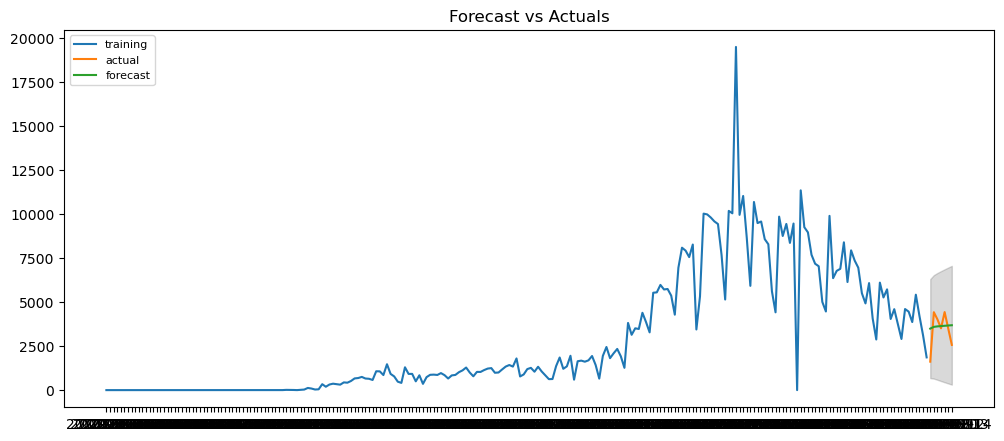

In [427]:
# Build Model
model = ARIMA(train, order=(1, 1, 2))  
fitted = model.fit(disp=-1)  
print(fitted.summary())

# Forecast
fc, se, conf = fitted.forecast(7, alpha=0.05)  # 95% conf

# Make as pandas series
fc_series = pd.Series(fc, index=test.index)
lower_series = pd.Series(conf[:, 0], index=test.index)
upper_series = pd.Series(conf[:, 1], index=test.index)

# Plot
plt.figure(figsize=(12,5), dpi=100)
plt.plot(train, label='training')
plt.plot(test, label='actual')
plt.plot(fc_series, label='forecast')
plt.fill_between(lower_series.index, lower_series, upper_series, 
                 color='k', alpha=.15)
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()

In [428]:
error = metrics.mean_squared_error(test, fc_series)
rmse=np.sqrt(error)
print('Test MSE: %.3f' % error)
print('RMSE of ARIMA: %.3f' % rmse)

Test MSE: 895523.708
RMSE of ARIMA: 946.321


In [429]:
def forecast_accuracy(forecast, actual):
    mape = np.mean(np.abs(forecast - actual)/np.abs(actual))  # MAPE
    me = np.mean(forecast - actual)             # ME
    mae = np.mean(np.abs(forecast - actual))    # MAE
    mpe = np.mean((forecast - actual)/actual)   # MPE
    rmse = np.mean((forecast - actual)**2)**.5  # RMSE
    corr = np.corrcoef(forecast, actual)[0,1]   # corr
    mins = np.amin(np.hstack([forecast[:,None], 
                              actual[:,None]]), axis=1)
    maxs = np.amax(np.hstack([forecast[:,None], 
                              actual[:,None]]), axis=1)
    minmax = 1 - np.mean(mins/maxs)             # minmax
    acf1 = acf(fc-test)[1]                      # ACF1
    return({'mape':mape, 'me':me, 'mae': mae, 
            'mpe': mpe, 'rmse':rmse, 'acf1':acf1, 
            'corr':corr, 'minmax':minmax})

forecast_accuracy(fc, test.values)


C:\Users\nikit\Anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:572: FutureWarning:

fft=True will become the default in a future version of statsmodels. To suppress this warning, explicitly set fft=False.



{'mape': 0.30612317991937016,
 'me': 182.46574796470628,
 'mae': 756.6832743487386,
 'mpe': 0.17380059635473533,
 'rmse': 946.3211443700599,
 'acf1': -0.17332752858923123,
 'corr': 0.4617121936603719,
 'minmax': 0.19771107633412466}

#### We can see that RMSE value of ARIMA < Random Forest Regressor < Decision tree, so ARIMA is the best model for this timeseries data

#### Use 5 different variables from the enrichment data to predict the spread rate (cases and deaths) of COVID-19 in a county. Compare Random Forest and Decision Trees (RMSE error).

In [497]:
#Loading the merged employment dataset
covid_emp = pd.read_csv('../data/emp_covid_large.csv')

In [531]:
#Choosing Texas state
emp_tx=covid_emp[covid_emp['State']=='TX']

In [532]:
emp_tx

,State,countyFIPS,County Name,Date,Num of Cases,Num of Deaths,population,Own,Ownership,Industry,Establishment Count,January Employment,February Employment,March Employment,Total Quarterly Wages,Average Weekly Wage,Employment Location Quotient Relative to U.S.,Total Wage Location Quotient Relative to U.S.
4367199,TX,48001,anderson county,2020-01-22,0,0,57735,0,Total Covered,"10 Total, all industries",1598,20096,20382,20439,238532006,904,1.00,1.00
4367200,TX,48001,anderson county,2020-01-22,0,0,57735,1,Federal Government,"10 Total, all industries",13,154,152,153,2128978,1070,0.39,0.37
4367201,TX,48001,anderson county,2020-01-22,0,0,57735,2,State Government,"10 Total, all industries",24,2984,2958,2942,37464579,973,4.49,4.93
4367202,TX,48001,anderson county,2020-01-22,0,0,57735,3,Local Government,"10 Total, all industries",46,2150,2167,2184,21649019,768,1.07,1.09
4367203,TX,48001,anderson county,2020-01-22,0,0,57735,5,Private,"10 Total, all industries",1515,14808,15105,15160,177289430,908,0.87,0.86
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4823893,TX,48507,zavala county,2020-09-14,282,14,11840,3,Local Government,"10 Total, all industries",30,853,854,850,6442790,581,3.39,2.95
4823894,TX,48507,zavala county,2020-09-14,282,14,11840,5,Private,"10 Total, all industries",137,1715,1679,1611,18999301,876,0.76,0.85
4823895,TX,48507,zavala county,2020-09-14,282,14,11840,5,Private,1013 Manufacturing,3,14,15,15,243368,1276,0.07,0.09
4823896,TX,48507,zavala county,2020-09-14,282,14,11840,5,Private,"1021 Trade, transportation, and utilities",25,342,333,309,4521719,1060,0.67,1.14


In [533]:
#Removing the number of 'Employment Location Quotient Relative to U.S.' and 'Total Wage Location Quotient Relative to U.S.columns
#as their value will be 1 for all the rows as we are taking total industries
emp_tx.drop(['Own','Employment Location Quotient Relative to U.S.','Total Wage Location Quotient Relative to U.S.'], axis=1, inplace=True)

C:\Users\nikit\Anaconda3\lib\site-packages\pandas\core\frame.py:4102: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [534]:
emp_tx

,State,countyFIPS,County Name,Date,Num of Cases,Num of Deaths,population,Ownership,Industry,Establishment Count,January Employment,February Employment,March Employment,Total Quarterly Wages,Average Weekly Wage
4367199,TX,48001,anderson county,2020-01-22,0,0,57735,Total Covered,"10 Total, all industries",1598,20096,20382,20439,238532006,904
4367200,TX,48001,anderson county,2020-01-22,0,0,57735,Federal Government,"10 Total, all industries",13,154,152,153,2128978,1070
4367201,TX,48001,anderson county,2020-01-22,0,0,57735,State Government,"10 Total, all industries",24,2984,2958,2942,37464579,973
4367202,TX,48001,anderson county,2020-01-22,0,0,57735,Local Government,"10 Total, all industries",46,2150,2167,2184,21649019,768
4367203,TX,48001,anderson county,2020-01-22,0,0,57735,Private,"10 Total, all industries",1515,14808,15105,15160,177289430,908
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4823893,TX,48507,zavala county,2020-09-14,282,14,11840,Local Government,"10 Total, all industries",30,853,854,850,6442790,581
4823894,TX,48507,zavala county,2020-09-14,282,14,11840,Private,"10 Total, all industries",137,1715,1679,1611,18999301,876
4823895,TX,48507,zavala county,2020-09-14,282,14,11840,Private,1013 Manufacturing,3,14,15,15,243368,1276
4823896,TX,48507,zavala county,2020-09-14,282,14,11840,Private,"1021 Trade, transportation, and utilities",25,342,333,309,4521719,1060


In [535]:
county1_emp = emp_tx[emp_tx["Ownership"].isin(["Total Covered"])]

In [536]:
county1_emp = county1_emp[county1_emp["Date"].isin(["2020-09-14"])]

In [537]:
county1_emp

,State,countyFIPS,County Name,Date,Num of Cases,Num of Deaths,population,Ownership,Industry,Establishment Count,January Employment,February Employment,March Employment,Total Quarterly Wages,Average Weekly Wage
4369087,TX,48001,anderson county,2020-09-14,2762,24,57735,Total Covered,"10 Total, all industries",1598,20096,20382,20439,238532006,904
4370983,TX,48003,andrews county,2020-09-14,400,8,18705,Total Covered,"10 Total, all industries",520,7807,7734,7731,135308469,1342
4372879,TX,48005,angelina county,2020-09-14,2072,77,86715,Total Covered,"10 Total, all industries",1911,34787,35038,34936,365288670,805
4374775,TX,48007,aransas county,2020-09-14,302,18,23510,Total Covered,"10 Total, all industries",604,5619,5655,5674,55712408,759
4376671,TX,48009,archer county,2020-09-14,67,1,8553,Total Covered,"10 Total, all industries",252,1638,1643,1642,15288617,717
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4816543,TX,48499,wood county,2020-09-14,452,18,45539,Total Covered,"10 Total, all industries",899,10395,10575,10554,102535345,751
4818439,TX,48501,yoakum county,2020-09-14,183,4,8713,Total Covered,"10 Total, all industries",295,3309,3285,3324,64376027,1498
4820335,TX,48503,young county,2020-09-14,246,6,18010,Total Covered,"10 Total, all industries",613,6502,6519,6448,72341476,857
4821995,TX,48505,zapata county,2020-09-14,317,5,14179,Total Covered,"10 Total, all industries",177,3329,3352,3352,41257868,949


In [545]:
#Taking previous weeks data as train and present as test
X = pd.DataFrame(county1_emp, columns=['Establishment Count', 'March Employment', 'Total Quarterly Wages', 'Average Weekly Wage'])
y = pd.DataFrame(county1_emp, columns=['Num of Cases'])#county1_emp.iloc[:,4].values.reshape(-1, 1) 
x_train = X[:229]
x_test = X[229:]
y_train = y[:229]
y_test = y[229:]


##### Decision tree regressor

In [546]:
#Object of decision tree
regress = DecisionTreeRegressor()  
  
# fit the regressor with X and Y data 
regress.fit(x_train, y_train) 

DecisionTreeRegressor()

In [547]:
y_pred = regress.predict(x_test)

###### Decision tree RMSE score

In [548]:
mse = metrics.mean_squared_error(y_test,y_pred)
rmse=np.sqrt(mse)
print("Decision tree RMSE:" ,rmse)

Decision tree RMSE: 2081.5717523064154


##### Feature importance of Decision tree

In [549]:
importance = regress.feature_importances_
print("Decision Tree feature importance:",importance)

Decision Tree feature importance: [0.11728634 0.86300527 0.01091517 0.00879322]


##### Random forest regressor

In [550]:
rf = RandomForestRegressor(n_estimators = 1000, random_state = 42)
# Train the model on training data
rf.fit(x_train, y_train)

C:\Users\nikit\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().



RandomForestRegressor(n_estimators=1000, random_state=42)

In [551]:
prediction = rf.predict(x_test)

In [552]:
mse = metrics.mean_squared_error(y_test,prediction)
rmse=np.sqrt(mse)
rmse

1878.6287301603688

##### Feature importance of RF

In [553]:
importance = rf.feature_importances_
importance

array([0.23371195, 0.56293294, 0.17145357, 0.03190154])

#### As we can see the variable March employment has the highest relative importance among all the variables for both decision tree and random forest regressors, so if people could work from home there would be less spread of the virus as employment affects the cases in a county.